In [21]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [22]:
# Phần code này dựa trên bài viết này
# https://www.sciencedirect.com/science/article/pii/S1877050919302789

# Import the libraries

In [23]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU, Flatten
import time
import datetime

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [24]:
# Hàm vẽ mô hình miêu tả giá trị từng thuộc tính
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [25]:
# Hàm thêm cột giá trị Ma, là đường trung bình động (Moving Average) của biến giá trị Close
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [26]:
# Class này kế thừa class TimeseriesGenerator
# Nó tạo ra các batch dữ liệu được chuẩn hóa (standarized)
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [27]:
# Giải thích các thông số đầu vào của class TimeseriesGenerator
# Data: Những dữ liệu liên tiếp nhau (axis 0 được kì vọng là time dimension)
# Target: Dữ liệu tương ứng với những timesteps trong data
# Length: Độ dài của các sequences đầu vào (Hay window, look-back)
# sampling_rate: Chu kỳ của các timestep input được lấy (VD: sampling_rate=2 
# thì cách 2 ngày lấy một lần)
# stride: Chu kỳ của các timestep output được lấy (VD: stride=2 
# thì cách 2 ngày lấy một lần, hay chú Sơn nói là số bước mà cửa sổ trượt)
# start_index, end_index: Khoảng dữ liệu được dùng
# bacth_size: số lượng samples 1 batch
# ([day1, day2, day3],[day4]) là 1 sample
# [([day1, day2, day3],[day4]), ([day2, day3, day4],[day5])] là 1 batch có 
# batch_size là 5
################Xét ví dụ sau############
# from keras.preprocessing.sequence import TimeseriesGenerator
# import numpy as np
# data = np.array([[i] for i in range(50)])
# targets = np.array([[i] for i in range(50)])
# data_gen = TimeseriesGenerator(data, targets,
#                                length=10, sampling_rate=2,
#                                batch_size=2)
# assert len(data_gen) == 20
# batch_0 = data_gen[0]
# x, y = batch_0
# assert np.array_equal(x,
#                       np.array([[[0], [2], [4], [6], [8]],
#                                 [[1], [3], [5], [7], [9]]]))
# assert np.array_equal(y,
#                       np.array([[10], [11]]))
# ==>length=10 nên những dữ liệu được pick cho input có index 0->9
# Và dữ liệu đầu tiên cho output có index là 10
# sampling_rate bằng 2 nên (index thứ i) - (index thứ i - 1) = 2
# Batch_size=2 --> Mỗi batch có 2 sample mà có 41 samples --> Có 21 batches

def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [28]:
# Hàm dùng để tính mean squared error cho generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [29]:
# Các hàm tính metrics từ 2 tập thực tế và dự đoán.
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [30]:
# Vì Discriminator trong bài toán này chỉ có hai giá trị đầu ra (giống/ không giống) nên dùng hàm phân loại nhị phân
# Tìm hiểu Binary Cross Entropy là gì tại đây:
# https://ndquy.github.io/posts/loss-function-p2/#:~:text=Binary%20Cross%2DEntropy%20Loss,tr%E1%BB%8B%20%7B0%2C%201%7D.
# Cross-entropy là hàm loss được sử dụng mặc định cho bài toán phân lớp nhị phân.
# Nó được thiết kế để sử dụng với bài toán phân loại nhị phân trong đó các giá trị mục tiêu nhận một trong 2 giá trị {0, 1}.
# Trang 402
def discriminator_loss(real_output, fake_output):
    # So sách kết quả dự đoán như thể nào với 1 (đúng) (real_loss)
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    # So sách kết quả dự đoán như thể nào với 0 (sai) (fake_loss)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    # Giá trị mất mát của Generator
    total_loss = real_loss + fake_loss
    return total_loss
# https://www.sciencedirect.com/science/article/pii/S1877050919302789
# Trang 403
def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse


## Generator

In [31]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    # return_sequences = True, Trả về cho lớp sau các điểm đầu ra trước đó thay vì chỉ các điểm đầu ra ở lớp cuối cùng
    # Trong mạng neural học sâu, kernel_initializer là một tham số được sử dụng để khởi tạo trọng số (weights) của các lớp (layer) trong mạng neural.
    lstm_1 = LSTM(units=10, return_sequences = True, activation=None, kernel_initializer='random_normal')(inputs)
    # Batch Normalization là một lớp (layer) được sử dụng trong mạng neural học sâu để chuẩn hóa đầu ra của một lớp trước khi đưa vào lớp kế tiếp
    # Cải thiện "vanishing gradient" và "exploding gradient", đồng thời giúp mô hình hội tụ nhanh hơn
    batch_norm1=tf.keras.layers.BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    lstm_1_droput = Dropout(0.3)(lstm_1_LRelu)
    lstm_2 = LSTM(units=10, return_sequences = False, activation=None, kernel_initializer='random_normal')(lstm_1_droput)
    batch_norm2=tf.keras.layers.BatchNormalization()(lstm_2)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    lstm_2_droput = Dropout(0.3)(lstm_2_LRelu)
    output_dense = Dense(n_features, activation=None)(lstm_2_droput)
    #  LeakyReLU
    # https://aicurious.io/blog/2019-09-23-cac-ham-kich-hoat-activation-function-trong-neural-networks
    output = LeakyReLU(alpha=0.3)(output_dense) 

    model = Model(inputs = inputs, outputs = output)
    model.compile(loss=None, metrics = [mse , mae, mape, rmse, ar])
    model.summary()

    return model
# Vì sao cần hàm kích hoạt, vì nếu có hàm kích hoạt mà là các lớp nơ ron đơn thuần xếp chồng lên nhau thì kết quả đầu ra đơn 
# là một hàm tuyến tính của giá trị đầu vào --> Việc xếp chồng mà k có hàm kích hoạt là vô nghĩa
# Sigmoid (0,1). Đạo hàm đẹp nhưng dễ bằng 0 (vanishing gradient), không có trung tâm nên hội tụ khó khăn
# tanh (-1,1). Cũng bão hòa hai đầu nhưng có trung tâm (O)
# ReLu max(0, x): Sử dụng khá nhiều gần đây do tốc độ hội tụ nhanh do nó k bị bão hòa 2 đầu
# --> Rectified Linear Unit: đơn vị tuyến tính được hiệu chỉnh
# Tính toán nhanh dO công thức đơn giản
# Nhược điểm là với những node < 0 thù activation chuyển thành 0 (Dying ReLU) (*)
# Leaky ReLU dùng để khắc phục ReLU
# LeakyReLU: f(x) = 1 với x<0 và f(x)=ax + 1 với x>=0 với a nhỏ
# Thay vì trả về 0 với x < 0 thì nó cố gắng tạo ra một đường xiên nhỏ



## Discriminator

In [32]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    # là một lớp sinh dữ liệu ngẫu nhiên nhằm giảm thiểu overfit
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [33]:
def train_step_def(sequences, sequences_end):
    # GradientTape trả về  Context Manager, quản lý quan sát các thay đổi của mô hình và cập nhật lại trọng số
    # Nó theo dõi các quá trình tính toán của mô hình trong quá trình lan truyền thuận và cập nhật trong quá trình lan truyền ngược
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Giải thích training=True 
        # https://stackoverflow.com/questions/57320371/what-does-training-true-mean-when-calling-a-tensorflow-keras-model
        generated_prediction = generator(sequences, training=True)
        # None là cách tăng dimension. VD: [1,2,3] --> [[1],[2],[3]]
        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [34]:
def train(dataset, dataset_val, epochs):
    # Biến history (training) và history_val (testing) lưu các thông số liên quan đến mse, rmse, mae, mape để vẽ đồ thị ở bước sau
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        # Với mỗi batch
        for sequence_batch, sequence_end_batch in dataset:
            # Tiến hành train, cập nhật weight bằng Gradient Tape cho hai mô hình G và D
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            # lấy ra giá trị của các loss function 
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        # Verbose là dài dòng, verbose=False có nghĩa là không xuất ra giá trị cụ thể
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        #Lưu các thông số vào biến history
        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

## Visualization

In [35]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [36]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [37]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [38]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [39]:
stock_code = "AAPL"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Ma
5,2000-01-10,0.910714,0.912946,0.845982,0.872768,0.742829,505064000,0.915960
6,2000-01-11,0.856585,0.887277,0.808036,0.828125,0.704832,441548800,0.890625
7,2000-01-12,0.848214,0.852679,0.772321,0.778460,0.662562,976068800,0.873214
8,2000-01-13,0.843610,0.881696,0.825893,0.863839,0.735229,1032684800,0.843192
9,2000-01-14,0.892857,0.912946,0.887277,0.896763,0.763251,390376000,0.846317
...,...,...,...,...,...,...,...,...
5278,2020-12-23,132.160004,132.429993,130.779999,130.960007,129.209290,88223700,128.656000
5279,2020-12-24,131.320007,133.460007,131.100006,131.970001,130.205780,54930100,129.286002
5280,2020-12-28,133.990005,137.339996,133.509995,136.690002,134.862701,124486200,129.940002
5281,2020-12-29,138.050003,138.789993,134.339996,134.869995,133.066986,121047300,131.946002


In [ ]:
for epochs in [200, 450, 700, 950, 1200, 1450, 1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm (LSTM)                 (None, 5, 10)             720       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                             

Time for epoch 54 is 0.8862507343292236 sec Generator Loss: 0.9665374755859375,  Discriminator_loss: 1.2210257053375244
Time for epoch 55 is 0.9292819499969482 sec Generator Loss: 0.9704409837722778,  Discriminator_loss: 1.2177338600158691
Time for epoch 56 is 0.886725664138794 sec Generator Loss: 0.9535319805145264,  Discriminator_loss: 1.2333165407180786
Time for epoch 57 is 0.8307745456695557 sec Generator Loss: 0.9561052322387695,  Discriminator_loss: 1.2328845262527466
Time for epoch 58 is 0.8293495178222656 sec Generator Loss: 0.9464114308357239,  Discriminator_loss: 1.2220590114593506
Time for epoch 59 is 0.7482724189758301 sec Generator Loss: 0.9536411762237549,  Discriminator_loss: 1.2189074754714966
Time for epoch 60 is 0.7521328926086426 sec Generator Loss: 0.9607991576194763,  Discriminator_loss: 1.2143036127090454
Time for epoch 61 is 0.8033237457275391 sec Generator Loss: 0.945461630821228,  Discriminator_loss: 1.2339675426483154
Time for epoch 62 is 0.7637665271759033 se

Time for epoch 123 is 0.7488982677459717 sec Generator Loss: 0.8894459009170532,  Discriminator_loss: 1.290138840675354
Time for epoch 124 is 0.7361938953399658 sec Generator Loss: 0.8863116502761841,  Discriminator_loss: 1.2887405157089233
Time for epoch 125 is 0.7321476936340332 sec Generator Loss: 0.8865547776222229,  Discriminator_loss: 1.2826236486434937
Time for epoch 126 is 0.7358465194702148 sec Generator Loss: 0.8909298181533813,  Discriminator_loss: 1.289448618888855
Time for epoch 127 is 0.7394149303436279 sec Generator Loss: 0.882996678352356,  Discriminator_loss: 1.286139726638794
Time for epoch 128 is 0.7377381324768066 sec Generator Loss: 0.872342050075531,  Discriminator_loss: 1.297791600227356
Time for epoch 129 is 0.7354767322540283 sec Generator Loss: 0.879546046257019,  Discriminator_loss: 1.2905248403549194
Time for epoch 130 is 0.7474837303161621 sec Generator Loss: 0.874497652053833,  Discriminator_loss: 1.286087989807129
Time for epoch 131 is 0.733696699142456 s

Time for epoch 192 is 0.7539248466491699 sec Generator Loss: 0.8846831321716309,  Discriminator_loss: 1.2755002975463867
Time for epoch 193 is 0.7511966228485107 sec Generator Loss: 0.9012677073478699,  Discriminator_loss: 1.2867666482925415
Time for epoch 194 is 0.7305712699890137 sec Generator Loss: 0.8733498454093933,  Discriminator_loss: 1.294726848602295
Time for epoch 195 is 0.7260301113128662 sec Generator Loss: 0.8757229447364807,  Discriminator_loss: 1.2975080013275146
Time for epoch 196 is 0.7674894332885742 sec Generator Loss: 0.8890965580940247,  Discriminator_loss: 1.281485676765442
Time for epoch 197 is 0.8003909587860107 sec Generator Loss: 0.8835352659225464,  Discriminator_loss: 1.2915302515029907
Time for epoch 198 is 0.7829530239105225 sec Generator Loss: 0.8887791037559509,  Discriminator_loss: 1.283769130706787
Time for epoch 199 is 0.8090267181396484 sec Generator Loss: 0.8861623406410217,  Discriminator_loss: 1.2868248224258423
Time for epoch 200 is 0.74748063087

Time for epoch 260 is 0.7315123081207275 sec Generator Loss: 0.8776416778564453,  Discriminator_loss: 1.298797607421875
Time for epoch 261 is 0.7310912609100342 sec Generator Loss: 0.8762879967689514,  Discriminator_loss: 1.2966961860656738
Time for epoch 262 is 0.7264432907104492 sec Generator Loss: 0.8757050633430481,  Discriminator_loss: 1.291623830795288
Time for epoch 263 is 0.7272934913635254 sec Generator Loss: 0.8726871609687805,  Discriminator_loss: 1.29531729221344
Time for epoch 264 is 0.7340047359466553 sec Generator Loss: 0.8667988777160645,  Discriminator_loss: 1.2977933883666992
Time for epoch 265 is 0.7459628582000732 sec Generator Loss: 0.8828288912773132,  Discriminator_loss: 1.2902880907058716
Time for epoch 266 is 0.7379477024078369 sec Generator Loss: 0.8817488551139832,  Discriminator_loss: 1.283554196357727
Time for epoch 267 is 0.7406342029571533 sec Generator Loss: 0.8786845207214355,  Discriminator_loss: 1.2984191179275513
Time for epoch 268 is 0.7290964126586

Time for epoch 329 is 0.7287135124206543 sec Generator Loss: 0.8831828832626343,  Discriminator_loss: 1.2937448024749756
Time for epoch 330 is 0.7287039756774902 sec Generator Loss: 0.8626922965049744,  Discriminator_loss: 1.3084825277328491
Time for epoch 331 is 0.7319819927215576 sec Generator Loss: 0.8705533742904663,  Discriminator_loss: 1.2886419296264648
Time for epoch 332 is 0.8002793788909912 sec Generator Loss: 0.8695895075798035,  Discriminator_loss: 1.3003321886062622
Time for epoch 333 is 0.7700464725494385 sec Generator Loss: 0.8592896461486816,  Discriminator_loss: 1.2966560125350952
Time for epoch 334 is 0.8131301403045654 sec Generator Loss: 0.8766617774963379,  Discriminator_loss: 1.2786736488342285
Time for epoch 335 is 0.7712936401367188 sec Generator Loss: 0.8865941762924194,  Discriminator_loss: 1.28132963180542
Time for epoch 336 is 0.7645008563995361 sec Generator Loss: 0.8924803137779236,  Discriminator_loss: 1.2817251682281494
Time for epoch 337 is 0.7678670883

Time for epoch 397 is 0.7362260818481445 sec Generator Loss: 0.8781462907791138,  Discriminator_loss: 1.2891144752502441
Time for epoch 398 is 0.7285027503967285 sec Generator Loss: 0.8808692097663879,  Discriminator_loss: 1.288933515548706
Time for epoch 399 is 0.7286653518676758 sec Generator Loss: 0.880493700504303,  Discriminator_loss: 1.2964271306991577
Time for epoch 400 is 0.7318325042724609 sec Generator Loss: 0.8859707713127136,  Discriminator_loss: 1.2870711088180542
Time for epoch 401 is 0.723778247833252 sec Generator Loss: 0.8723939061164856,  Discriminator_loss: 1.2986408472061157
Time for epoch 402 is 0.7263145446777344 sec Generator Loss: 0.8722090721130371,  Discriminator_loss: 1.3045620918273926
Time for epoch 403 is 0.7386422157287598 sec Generator Loss: 0.8594976663589478,  Discriminator_loss: 1.3091530799865723
Time for epoch 404 is 0.7360944747924805 sec Generator Loss: 0.888003408908844,  Discriminator_loss: 1.2834923267364502
Time for epoch 405 is 0.729292631149

Time for epoch 465 is 0.7753243446350098 sec Generator Loss: 0.8897967338562012,  Discriminator_loss: 1.279677391052246
Time for epoch 466 is 0.7994277477264404 sec Generator Loss: 0.8996478319168091,  Discriminator_loss: 1.2783957719802856
Time for epoch 467 is 0.7772386074066162 sec Generator Loss: 0.887017011642456,  Discriminator_loss: 1.2845098972320557
Time for epoch 468 is 0.7634637355804443 sec Generator Loss: 0.9010618329048157,  Discriminator_loss: 1.2712739706039429
Time for epoch 469 is 0.753424882888794 sec Generator Loss: 0.8956452012062073,  Discriminator_loss: 1.2847301959991455
Time for epoch 470 is 0.7334671020507812 sec Generator Loss: 0.899351954460144,  Discriminator_loss: 1.2825852632522583
Time for epoch 471 is 0.7269363403320312 sec Generator Loss: 0.8875845074653625,  Discriminator_loss: 1.2879453897476196
Time for epoch 472 is 0.7316591739654541 sec Generator Loss: 0.8904097676277161,  Discriminator_loss: 1.2856608629226685
Time for epoch 473 is 0.729752063751

Time for epoch 533 is 0.7503111362457275 sec Generator Loss: 0.9150617122650146,  Discriminator_loss: 1.2578274011611938
Time for epoch 534 is 0.7373456954956055 sec Generator Loss: 0.8982815742492676,  Discriminator_loss: 1.2778698205947876
Time for epoch 535 is 0.7263755798339844 sec Generator Loss: 0.900665819644928,  Discriminator_loss: 1.2816458940505981
Time for epoch 536 is 0.7702751159667969 sec Generator Loss: 0.8996360301971436,  Discriminator_loss: 1.27850341796875
Time for epoch 537 is 0.7669398784637451 sec Generator Loss: 0.8954294323921204,  Discriminator_loss: 1.2792930603027344
Time for epoch 538 is 0.73152756690979 sec Generator Loss: 0.8893232345581055,  Discriminator_loss: 1.2909743785858154
Time for epoch 539 is 0.7380549907684326 sec Generator Loss: 0.9074569940567017,  Discriminator_loss: 1.2756115198135376
Time for epoch 540 is 0.7396795749664307 sec Generator Loss: 0.8964621424674988,  Discriminator_loss: 1.2911041975021362
Time for epoch 541 is 0.7402667999267

Time for epoch 602 is 0.7373983860015869 sec Generator Loss: 0.9088788628578186,  Discriminator_loss: 1.273633360862732
Time for epoch 603 is 0.7336421012878418 sec Generator Loss: 0.9256643652915955,  Discriminator_loss: 1.266038179397583
Time for epoch 604 is 0.7325983047485352 sec Generator Loss: 0.9043155908584595,  Discriminator_loss: 1.2740033864974976
Time for epoch 605 is 0.7353270053863525 sec Generator Loss: 0.9267358183860779,  Discriminator_loss: 1.2634059190750122
Time for epoch 606 is 0.7352283000946045 sec Generator Loss: 0.9139875769615173,  Discriminator_loss: 1.2663729190826416
Time for epoch 607 is 0.724907398223877 sec Generator Loss: 0.9132729172706604,  Discriminator_loss: 1.275700569152832
Time for epoch 608 is 0.7324624061584473 sec Generator Loss: 0.900221586227417,  Discriminator_loss: 1.2755944728851318
Time for epoch 609 is 0.7327690124511719 sec Generator Loss: 0.9222719073295593,  Discriminator_loss: 1.2600313425064087
Time for epoch 610 is 0.7318015098571

Time for epoch 671 is 0.8220551013946533 sec Generator Loss: 0.9039548635482788,  Discriminator_loss: 1.273085594177246
Time for epoch 672 is 0.7332723140716553 sec Generator Loss: 0.9159036874771118,  Discriminator_loss: 1.2649531364440918
Time for epoch 673 is 0.72955322265625 sec Generator Loss: 0.9319186210632324,  Discriminator_loss: 1.2506200075149536
Time for epoch 674 is 0.7322196960449219 sec Generator Loss: 0.9225157499313354,  Discriminator_loss: 1.2630698680877686
Time for epoch 675 is 1.0739896297454834 sec Generator Loss: 0.9187604784965515,  Discriminator_loss: 1.2700719833374023
Time for epoch 676 is 0.7511343955993652 sec Generator Loss: 0.9238767623901367,  Discriminator_loss: 1.2586686611175537
Time for epoch 677 is 0.7648866176605225 sec Generator Loss: 0.9171196222305298,  Discriminator_loss: 1.2685641050338745
Time for epoch 678 is 0.7302651405334473 sec Generator Loss: 0.9094937443733215,  Discriminator_loss: 1.2724276781082153
Time for epoch 679 is 0.74317550659

Time for epoch 739 is 0.7769434452056885 sec Generator Loss: 0.9127457737922668,  Discriminator_loss: 1.2755624055862427
Time for epoch 740 is 0.7327582836151123 sec Generator Loss: 0.913183867931366,  Discriminator_loss: 1.2730817794799805
Time for epoch 741 is 0.728827953338623 sec Generator Loss: 0.921504557132721,  Discriminator_loss: 1.26736319065094
Time for epoch 742 is 0.7385649681091309 sec Generator Loss: 0.9259800314903259,  Discriminator_loss: 1.2626310586929321
Time for epoch 743 is 0.7268977165222168 sec Generator Loss: 0.9205823540687561,  Discriminator_loss: 1.268229365348816
Time for epoch 744 is 0.732302188873291 sec Generator Loss: 0.925753653049469,  Discriminator_loss: 1.2646708488464355
Time for epoch 745 is 0.7367143630981445 sec Generator Loss: 0.9224445223808289,  Discriminator_loss: 1.268847107887268
Time for epoch 746 is 0.7369058132171631 sec Generator Loss: 0.918988823890686,  Discriminator_loss: 1.2670446634292603
Time for epoch 747 is 0.7393651008605957 s

Time for epoch 808 is 0.7610299587249756 sec Generator Loss: 0.9071778059005737,  Discriminator_loss: 1.2715139389038086
Time for epoch 809 is 0.765228271484375 sec Generator Loss: 0.9138748049736023,  Discriminator_loss: 1.2720683813095093
Time for epoch 810 is 0.8061881065368652 sec Generator Loss: 0.9015585780143738,  Discriminator_loss: 1.2850266695022583
Time for epoch 811 is 0.9585165977478027 sec Generator Loss: 0.8912699818611145,  Discriminator_loss: 1.2795953750610352
Time for epoch 812 is 0.8412957191467285 sec Generator Loss: 0.9043262004852295,  Discriminator_loss: 1.285881757736206
Time for epoch 813 is 0.8553774356842041 sec Generator Loss: 0.903002917766571,  Discriminator_loss: 1.27493417263031
Time for epoch 814 is 0.8029918670654297 sec Generator Loss: 0.8973516821861267,  Discriminator_loss: 1.2884793281555176
Time for epoch 815 is 0.8008646965026855 sec Generator Loss: 0.9059721231460571,  Discriminator_loss: 1.285964012145996
Time for epoch 816 is 0.77892136573791

Time for epoch 877 is 0.7444791793823242 sec Generator Loss: 0.8908193707466125,  Discriminator_loss: 1.2939746379852295
Time for epoch 878 is 0.7347791194915771 sec Generator Loss: 0.882753312587738,  Discriminator_loss: 1.3064205646514893
Time for epoch 879 is 0.7340617179870605 sec Generator Loss: 0.8941263556480408,  Discriminator_loss: 1.293849229812622
Time for epoch 880 is 0.7475605010986328 sec Generator Loss: 0.8789332509040833,  Discriminator_loss: 1.2978461980819702
Time for epoch 881 is 0.7355365753173828 sec Generator Loss: 0.8922809362411499,  Discriminator_loss: 1.2867579460144043
Time for epoch 882 is 0.769834041595459 sec Generator Loss: 0.8820086121559143,  Discriminator_loss: 1.2994704246520996
Time for epoch 883 is 0.777911901473999 sec Generator Loss: 0.879875123500824,  Discriminator_loss: 1.2936210632324219
Time for epoch 884 is 0.7438216209411621 sec Generator Loss: 0.8839523196220398,  Discriminator_loss: 1.292893409729004
Time for epoch 885 is 0.73735237121582

Time for epoch 945 is 0.7347879409790039 sec Generator Loss: 0.8834648132324219,  Discriminator_loss: 1.2856146097183228
Time for epoch 946 is 0.7453596591949463 sec Generator Loss: 0.8844039440155029,  Discriminator_loss: 1.295793056488037
Time for epoch 947 is 0.7409489154815674 sec Generator Loss: 0.8883039951324463,  Discriminator_loss: 1.2788091897964478
Time for epoch 948 is 0.7364680767059326 sec Generator Loss: 0.8974758386611938,  Discriminator_loss: 1.2957969903945923
Time for epoch 949 is 0.7327349185943604 sec Generator Loss: 0.8895683884620667,  Discriminator_loss: 1.2930139303207397
Time for epoch 950 is 0.7338259220123291 sec Generator Loss: 0.8864099383354187,  Discriminator_loss: 1.2881605625152588


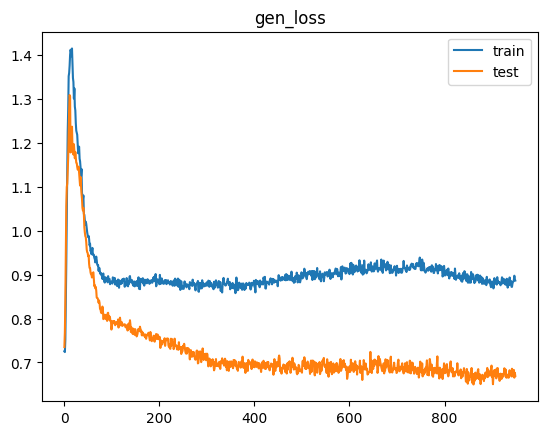

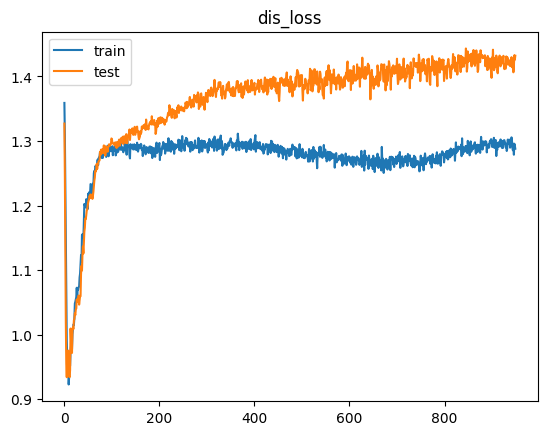

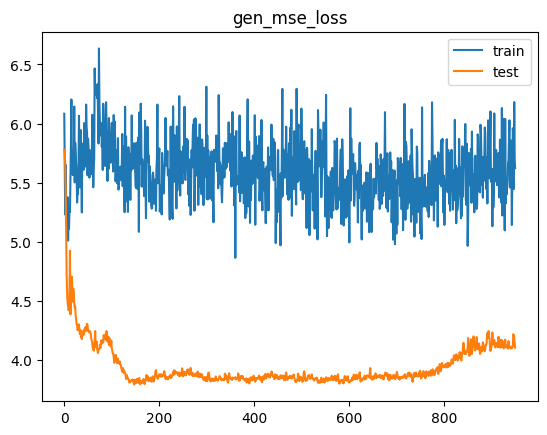

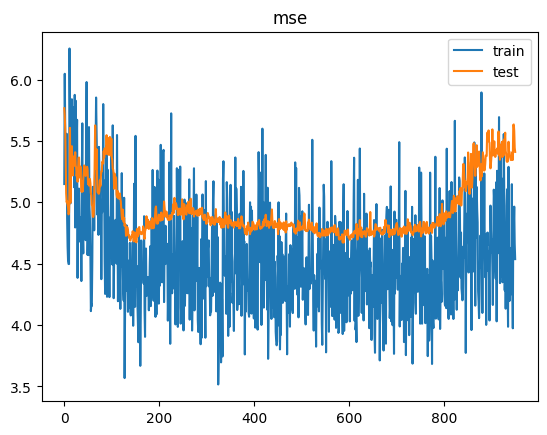

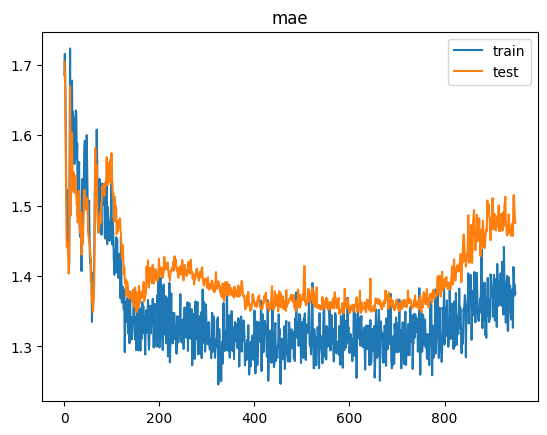

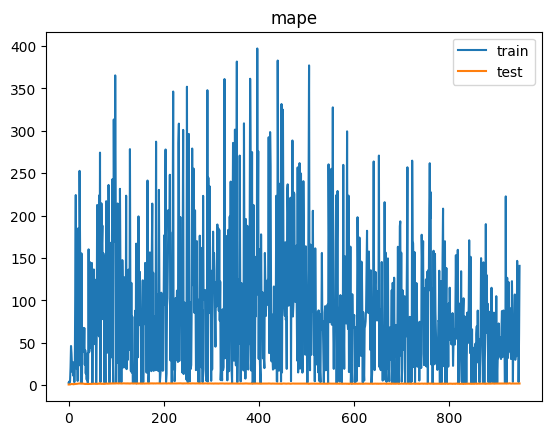

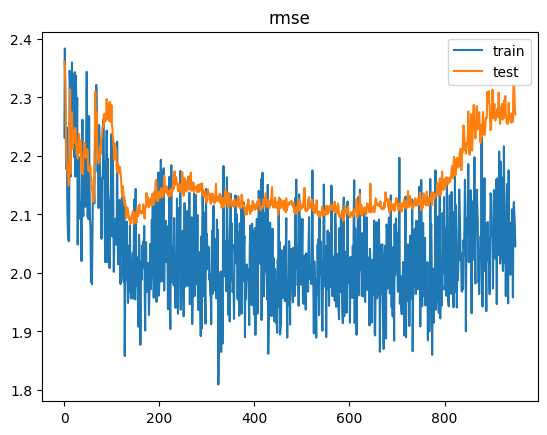

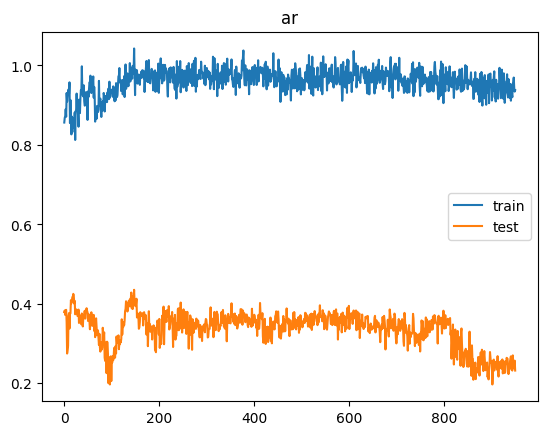

2/2 [==============================] - 0s 3ms/step


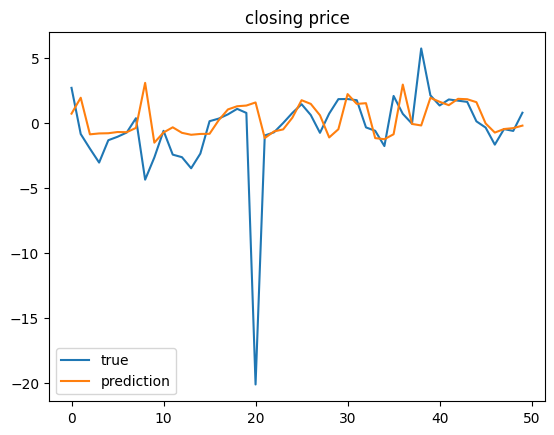

[MSE Baseline] train: 4.608659532487709  test: 4.679867713895856
Delta time with epochs = 950: 0:12:13.767789
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 lstm_3 (LSTM) 

Time for epoch 53 is 0.7378149032592773 sec Generator Loss: 0.9554169178009033,  Discriminator_loss: 1.2360589504241943
Time for epoch 54 is 0.732027530670166 sec Generator Loss: 0.9520536065101624,  Discriminator_loss: 1.2394651174545288
Time for epoch 55 is 0.7390704154968262 sec Generator Loss: 0.9554225206375122,  Discriminator_loss: 1.2348439693450928
Time for epoch 56 is 0.740931510925293 sec Generator Loss: 0.9467666745185852,  Discriminator_loss: 1.2432624101638794
Time for epoch 57 is 0.7386844158172607 sec Generator Loss: 0.9439010620117188,  Discriminator_loss: 1.251236081123352
Time for epoch 58 is 0.736642599105835 sec Generator Loss: 0.9354063868522644,  Discriminator_loss: 1.244391679763794
Time for epoch 59 is 0.7469000816345215 sec Generator Loss: 0.9381373524665833,  Discriminator_loss: 1.2518820762634277
Time for epoch 60 is 0.7529919147491455 sec Generator Loss: 0.9420311450958252,  Discriminator_loss: 1.2547255754470825
Time for epoch 61 is 0.9719958305358887 sec G

Time for epoch 122 is 0.7786033153533936 sec Generator Loss: 0.9067170023918152,  Discriminator_loss: 1.2863109111785889
Time for epoch 123 is 0.7852737903594971 sec Generator Loss: 0.8964830040931702,  Discriminator_loss: 1.287231206893921
Time for epoch 124 is 0.8232553005218506 sec Generator Loss: 0.8862820863723755,  Discriminator_loss: 1.2884286642074585
Time for epoch 125 is 0.7582619190216064 sec Generator Loss: 0.9051077961921692,  Discriminator_loss: 1.2763181924819946
Time for epoch 126 is 0.7441632747650146 sec Generator Loss: 0.8869898319244385,  Discriminator_loss: 1.2963930368423462
Time for epoch 127 is 0.7531673908233643 sec Generator Loss: 0.9010887742042542,  Discriminator_loss: 1.2828782796859741
Time for epoch 128 is 0.7403740882873535 sec Generator Loss: 0.8957195281982422,  Discriminator_loss: 1.2935047149658203
Time for epoch 129 is 0.7385120391845703 sec Generator Loss: 0.8954598903656006,  Discriminator_loss: 1.283320665359497
Time for epoch 130 is 0.7475972175

Time for epoch 191 is 0.7896125316619873 sec Generator Loss: 0.901459813117981,  Discriminator_loss: 1.2883875370025635
Time for epoch 192 is 0.8210203647613525 sec Generator Loss: 0.9119259119033813,  Discriminator_loss: 1.2719913721084595
Time for epoch 193 is 0.8397960662841797 sec Generator Loss: 0.9110716581344604,  Discriminator_loss: 1.2715051174163818
Time for epoch 194 is 0.8508689403533936 sec Generator Loss: 0.9123780727386475,  Discriminator_loss: 1.2649935483932495
Time for epoch 195 is 0.8029122352600098 sec Generator Loss: 0.9105967879295349,  Discriminator_loss: 1.271818995475769
Time for epoch 196 is 0.8981175422668457 sec Generator Loss: 0.9104114174842834,  Discriminator_loss: 1.2743436098098755
Time for epoch 197 is 0.8355836868286133 sec Generator Loss: 0.9084032773971558,  Discriminator_loss: 1.271201729774475
Time for epoch 198 is 0.7716748714447021 sec Generator Loss: 0.9006417989730835,  Discriminator_loss: 1.2689399719238281
Time for epoch 199 is 0.74281048774

Time for epoch 259 is 0.7604713439941406 sec Generator Loss: 0.8970096111297607,  Discriminator_loss: 1.27946937084198
Time for epoch 260 is 0.8142914772033691 sec Generator Loss: 0.8980287313461304,  Discriminator_loss: 1.2848811149597168
Time for epoch 261 is 0.8123784065246582 sec Generator Loss: 0.9004045724868774,  Discriminator_loss: 1.2820826768875122
Time for epoch 262 is 0.8308086395263672 sec Generator Loss: 0.905651330947876,  Discriminator_loss: 1.2787121534347534
Time for epoch 263 is 0.8485708236694336 sec Generator Loss: 0.8992577791213989,  Discriminator_loss: 1.2851027250289917
Time for epoch 264 is 0.8228030204772949 sec Generator Loss: 0.8922266960144043,  Discriminator_loss: 1.2890443801879883
Time for epoch 265 is 0.8919680118560791 sec Generator Loss: 0.8983150720596313,  Discriminator_loss: 1.289389729499817
Time for epoch 266 is 0.9472239017486572 sec Generator Loss: 0.9068617224693298,  Discriminator_loss: 1.273735761642456
Time for epoch 267 is 0.9375801086425

Time for epoch 328 is 0.7876896858215332 sec Generator Loss: 0.8944486379623413,  Discriminator_loss: 1.2756294012069702
Time for epoch 329 is 0.7906064987182617 sec Generator Loss: 0.9042261242866516,  Discriminator_loss: 1.2747093439102173
Time for epoch 330 is 0.7801876068115234 sec Generator Loss: 0.9064851403236389,  Discriminator_loss: 1.2749557495117188
Time for epoch 331 is 0.7908670902252197 sec Generator Loss: 0.9117100238800049,  Discriminator_loss: 1.2733535766601562
Time for epoch 332 is 0.8015413284301758 sec Generator Loss: 0.9142118096351624,  Discriminator_loss: 1.2727049589157104
Time for epoch 333 is 0.7500166893005371 sec Generator Loss: 0.9151365756988525,  Discriminator_loss: 1.286266565322876
Time for epoch 334 is 0.750312328338623 sec Generator Loss: 0.9026716351509094,  Discriminator_loss: 1.2878403663635254
Time for epoch 335 is 0.7500936985015869 sec Generator Loss: 0.9019442796707153,  Discriminator_loss: 1.2807798385620117
Time for epoch 336 is 0.7605473995

Time for epoch 396 is 0.8571748733520508 sec Generator Loss: 0.913197934627533,  Discriminator_loss: 1.2641654014587402
Time for epoch 397 is 0.8457064628601074 sec Generator Loss: 0.9252271056175232,  Discriminator_loss: 1.273415446281433
Time for epoch 398 is 0.8681449890136719 sec Generator Loss: 0.913634181022644,  Discriminator_loss: 1.2794309854507446
Time for epoch 399 is 0.8918702602386475 sec Generator Loss: 0.8937417268753052,  Discriminator_loss: 1.2821975946426392
Time for epoch 400 is 0.8515937328338623 sec Generator Loss: 0.9112513065338135,  Discriminator_loss: 1.286001205444336
Time for epoch 401 is 0.7887113094329834 sec Generator Loss: 0.9151716232299805,  Discriminator_loss: 1.2724295854568481
Time for epoch 402 is 0.8119533061981201 sec Generator Loss: 0.9156967401504517,  Discriminator_loss: 1.2767949104309082
Time for epoch 403 is 0.7932438850402832 sec Generator Loss: 0.9075443148612976,  Discriminator_loss: 1.281659483909607
Time for epoch 404 is 0.8056840896606

Time for epoch 464 is 0.751213788986206 sec Generator Loss: 0.9071042537689209,  Discriminator_loss: 1.2698285579681396
Time for epoch 465 is 0.7886285781860352 sec Generator Loss: 0.9115045666694641,  Discriminator_loss: 1.2638877630233765
Time for epoch 466 is 0.7918555736541748 sec Generator Loss: 0.9051691293716431,  Discriminator_loss: 1.2731597423553467
Time for epoch 467 is 0.800574779510498 sec Generator Loss: 0.9121971130371094,  Discriminator_loss: 1.2692188024520874
Time for epoch 468 is 0.8094444274902344 sec Generator Loss: 0.9217246174812317,  Discriminator_loss: 1.268939733505249
Time for epoch 469 is 0.7555849552154541 sec Generator Loss: 0.9038359522819519,  Discriminator_loss: 1.2775909900665283
Time for epoch 470 is 0.7541680335998535 sec Generator Loss: 0.9236685633659363,  Discriminator_loss: 1.2671722173690796
Time for epoch 471 is 0.7626030445098877 sec Generator Loss: 0.9145522713661194,  Discriminator_loss: 1.2828792333602905
Time for epoch 472 is 0.74459218978

Time for epoch 532 is 0.7409541606903076 sec Generator Loss: 0.9194352626800537,  Discriminator_loss: 1.2768464088439941
Time for epoch 533 is 0.7543227672576904 sec Generator Loss: 0.9055940508842468,  Discriminator_loss: 1.277614712715149
Time for epoch 534 is 0.7449533939361572 sec Generator Loss: 0.9258744120597839,  Discriminator_loss: 1.2671200037002563
Time for epoch 535 is 0.770179271697998 sec Generator Loss: 0.9122922420501709,  Discriminator_loss: 1.2781695127487183
Time for epoch 536 is 0.7707841396331787 sec Generator Loss: 0.9165223836898804,  Discriminator_loss: 1.2727487087249756
Time for epoch 537 is 0.7999734878540039 sec Generator Loss: 0.9095785021781921,  Discriminator_loss: 1.2736563682556152
Time for epoch 538 is 0.7791111469268799 sec Generator Loss: 0.9159822463989258,  Discriminator_loss: 1.2740817070007324
Time for epoch 539 is 0.8007044792175293 sec Generator Loss: 0.9144895076751709,  Discriminator_loss: 1.270963191986084
Time for epoch 540 is 0.78936910629

Time for epoch 600 is 0.7826426029205322 sec Generator Loss: 0.9043376445770264,  Discriminator_loss: 1.276605486869812
Time for epoch 601 is 0.77895188331604 sec Generator Loss: 0.9130983948707581,  Discriminator_loss: 1.2753983736038208
Time for epoch 602 is 0.7820467948913574 sec Generator Loss: 0.9134832620620728,  Discriminator_loss: 1.2761609554290771
Time for epoch 603 is 0.9738140106201172 sec Generator Loss: 0.905143678188324,  Discriminator_loss: 1.2864762544631958
Time for epoch 604 is 0.9436206817626953 sec Generator Loss: 0.9060429930686951,  Discriminator_loss: 1.2729958295822144
Time for epoch 605 is 0.8617432117462158 sec Generator Loss: 0.9086006879806519,  Discriminator_loss: 1.268439531326294
Time for epoch 606 is 0.8289825916290283 sec Generator Loss: 0.9162324666976929,  Discriminator_loss: 1.2744710445404053
Time for epoch 607 is 0.8505942821502686 sec Generator Loss: 0.9157522916793823,  Discriminator_loss: 1.26827871799469
Time for epoch 608 is 0.943742036819458

Time for epoch 669 is 0.7452752590179443 sec Generator Loss: 0.9228075742721558,  Discriminator_loss: 1.2629314661026
Time for epoch 670 is 0.7596397399902344 sec Generator Loss: 0.9135290384292603,  Discriminator_loss: 1.2679426670074463
Time for epoch 671 is 0.7499456405639648 sec Generator Loss: 0.9153150916099548,  Discriminator_loss: 1.2780650854110718
Time for epoch 672 is 0.7631897926330566 sec Generator Loss: 0.9161657094955444,  Discriminator_loss: 1.273496150970459
Time for epoch 673 is 0.8433046340942383 sec Generator Loss: 0.8992857933044434,  Discriminator_loss: 1.2859753370285034
Time for epoch 674 is 0.7828867435455322 sec Generator Loss: 0.9059743881225586,  Discriminator_loss: 1.2819124460220337
Time for epoch 675 is 0.7555336952209473 sec Generator Loss: 0.9115244746208191,  Discriminator_loss: 1.276388168334961
Time for epoch 676 is 0.7456223964691162 sec Generator Loss: 0.9140962958335876,  Discriminator_loss: 1.2719004154205322
Time for epoch 677 is 0.7832746505737

Time for epoch 737 is 0.8745391368865967 sec Generator Loss: 0.9173333644866943,  Discriminator_loss: 1.2674009799957275
Time for epoch 738 is 0.8383550643920898 sec Generator Loss: 0.9052031636238098,  Discriminator_loss: 1.2752103805541992
Time for epoch 739 is 0.8316121101379395 sec Generator Loss: 0.9110423922538757,  Discriminator_loss: 1.2783485651016235
Time for epoch 740 is 0.8211593627929688 sec Generator Loss: 0.9123523235321045,  Discriminator_loss: 1.2747392654418945
Time for epoch 741 is 0.7900879383087158 sec Generator Loss: 0.9197409152984619,  Discriminator_loss: 1.2650927305221558
Time for epoch 742 is 0.8101558685302734 sec Generator Loss: 0.9030906558036804,  Discriminator_loss: 1.2838586568832397
Time for epoch 743 is 0.8609557151794434 sec Generator Loss: 0.9043397903442383,  Discriminator_loss: 1.2762705087661743
Time for epoch 744 is 0.8158800601959229 sec Generator Loss: 0.895550012588501,  Discriminator_loss: 1.284697413444519
Time for epoch 745 is 0.7964982986

Time for epoch 805 is 0.7385928630828857 sec Generator Loss: 0.9004697203636169,  Discriminator_loss: 1.2873902320861816
Time for epoch 806 is 0.7480301856994629 sec Generator Loss: 0.9137412905693054,  Discriminator_loss: 1.2678431272506714
Time for epoch 807 is 0.808117151260376 sec Generator Loss: 0.9075338840484619,  Discriminator_loss: 1.2793021202087402
Time for epoch 808 is 0.7924063205718994 sec Generator Loss: 0.8951902985572815,  Discriminator_loss: 1.2778615951538086
Time for epoch 809 is 0.7815642356872559 sec Generator Loss: 0.916495680809021,  Discriminator_loss: 1.2692209482192993
Time for epoch 810 is 0.7866406440734863 sec Generator Loss: 0.9245114326477051,  Discriminator_loss: 1.2735439538955688
Time for epoch 811 is 0.9856369495391846 sec Generator Loss: 0.9177988171577454,  Discriminator_loss: 1.271847128868103
Time for epoch 812 is 0.8553862571716309 sec Generator Loss: 0.9218694567680359,  Discriminator_loss: 1.265058994293213
Time for epoch 813 is 0.806768655776

Time for epoch 873 is 0.7980501651763916 sec Generator Loss: 0.9173846244812012,  Discriminator_loss: 1.2670540809631348
Time for epoch 874 is 0.7942390441894531 sec Generator Loss: 0.9115021824836731,  Discriminator_loss: 1.2775827646255493
Time for epoch 875 is 0.7960989475250244 sec Generator Loss: 0.9013394713401794,  Discriminator_loss: 1.2865084409713745
Time for epoch 876 is 0.7610664367675781 sec Generator Loss: 0.9270378947257996,  Discriminator_loss: 1.2657469511032104
Time for epoch 877 is 0.7412593364715576 sec Generator Loss: 0.9099363684654236,  Discriminator_loss: 1.2746456861495972
Time for epoch 878 is 0.7470459938049316 sec Generator Loss: 0.9082374572753906,  Discriminator_loss: 1.284176230430603
Time for epoch 879 is 0.7427663803100586 sec Generator Loss: 0.9150061011314392,  Discriminator_loss: 1.2851072549819946
Time for epoch 880 is 0.7430768013000488 sec Generator Loss: 0.9041131734848022,  Discriminator_loss: 1.285028338432312
Time for epoch 881 is 0.7844831943

Time for epoch 941 is 0.8033163547515869 sec Generator Loss: 0.9196873307228088,  Discriminator_loss: 1.2789783477783203
Time for epoch 942 is 0.7929811477661133 sec Generator Loss: 0.9204227328300476,  Discriminator_loss: 1.279372215270996
Time for epoch 943 is 0.7918744087219238 sec Generator Loss: 0.9056132435798645,  Discriminator_loss: 1.2807005643844604
Time for epoch 944 is 0.8327193260192871 sec Generator Loss: 0.9043969511985779,  Discriminator_loss: 1.2813469171524048
Time for epoch 945 is 0.802201509475708 sec Generator Loss: 0.9013990759849548,  Discriminator_loss: 1.2800211906433105
Time for epoch 946 is 0.7909717559814453 sec Generator Loss: 0.9081712365150452,  Discriminator_loss: 1.2808994054794312
Time for epoch 947 is 0.7954936027526855 sec Generator Loss: 0.9200128316879272,  Discriminator_loss: 1.2710658311843872
Time for epoch 948 is 0.782806396484375 sec Generator Loss: 0.9045813083648682,  Discriminator_loss: 1.283130407333374
Time for epoch 949 is 0.758860349655

Time for epoch 1009 is 0.784351110458374 sec Generator Loss: 0.9163234829902649,  Discriminator_loss: 1.2804205417633057
Time for epoch 1010 is 0.7411682605743408 sec Generator Loss: 0.922812283039093,  Discriminator_loss: 1.268770456314087
Time for epoch 1011 is 0.7483508586883545 sec Generator Loss: 0.9066222906112671,  Discriminator_loss: 1.2793022394180298
Time for epoch 1012 is 0.7747330665588379 sec Generator Loss: 0.9159249663352966,  Discriminator_loss: 1.2738450765609741
Time for epoch 1013 is 0.8062644004821777 sec Generator Loss: 0.9258943796157837,  Discriminator_loss: 1.2761098146438599
Time for epoch 1014 is 0.7897131443023682 sec Generator Loss: 0.9058650732040405,  Discriminator_loss: 1.2831028699874878
Time for epoch 1015 is 0.7828245162963867 sec Generator Loss: 0.9212145805358887,  Discriminator_loss: 1.2733691930770874
Time for epoch 1016 is 0.7959320545196533 sec Generator Loss: 0.9162008762359619,  Discriminator_loss: 1.2705992460250854
Time for epoch 1017 is 0.80

Time for epoch 1077 is 0.8036904335021973 sec Generator Loss: 0.9094662070274353,  Discriminator_loss: 1.281766653060913
Time for epoch 1078 is 0.7804265022277832 sec Generator Loss: 0.9288709759712219,  Discriminator_loss: 1.262482762336731
Time for epoch 1079 is 0.7691433429718018 sec Generator Loss: 0.908862292766571,  Discriminator_loss: 1.2776622772216797
Time for epoch 1080 is 0.8020346164703369 sec Generator Loss: 0.910777747631073,  Discriminator_loss: 1.2809724807739258
Time for epoch 1081 is 0.8197684288024902 sec Generator Loss: 0.9097353219985962,  Discriminator_loss: 1.270111322402954
Time for epoch 1082 is 0.8911125659942627 sec Generator Loss: 0.9152672290802002,  Discriminator_loss: 1.2733263969421387
Time for epoch 1083 is 0.9115126132965088 sec Generator Loss: 0.9105349779129028,  Discriminator_loss: 1.2814234495162964
Time for epoch 1084 is 0.8666503429412842 sec Generator Loss: 0.9203917384147644,  Discriminator_loss: 1.2673516273498535
Time for epoch 1085 is 0.8873

Time for epoch 1145 is 0.7532651424407959 sec Generator Loss: 0.9087473154067993,  Discriminator_loss: 1.2889671325683594
Time for epoch 1146 is 0.7594478130340576 sec Generator Loss: 0.9213014841079712,  Discriminator_loss: 1.269136667251587
Time for epoch 1147 is 0.7520861625671387 sec Generator Loss: 0.9173965454101562,  Discriminator_loss: 1.2748496532440186
Time for epoch 1148 is 0.7412066459655762 sec Generator Loss: 0.9258525371551514,  Discriminator_loss: 1.271869421005249
Time for epoch 1149 is 0.7611873149871826 sec Generator Loss: 0.9106257557868958,  Discriminator_loss: 1.283104419708252
Time for epoch 1150 is 0.7739408016204834 sec Generator Loss: 0.9122735857963562,  Discriminator_loss: 1.2705703973770142
Time for epoch 1151 is 0.7619802951812744 sec Generator Loss: 0.9222840666770935,  Discriminator_loss: 1.2668330669403076
Time for epoch 1152 is 0.7653825283050537 sec Generator Loss: 0.9041391015052795,  Discriminator_loss: 1.287139654159546
Time for epoch 1153 is 0.755

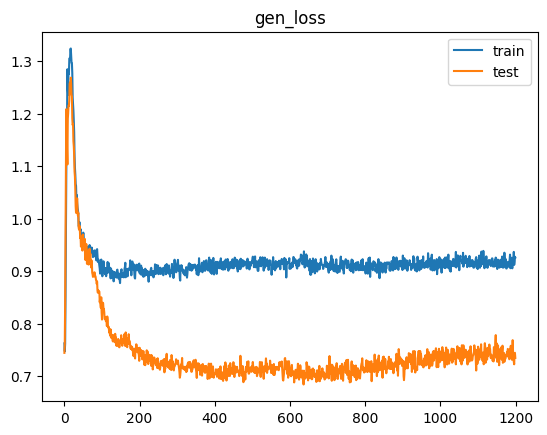

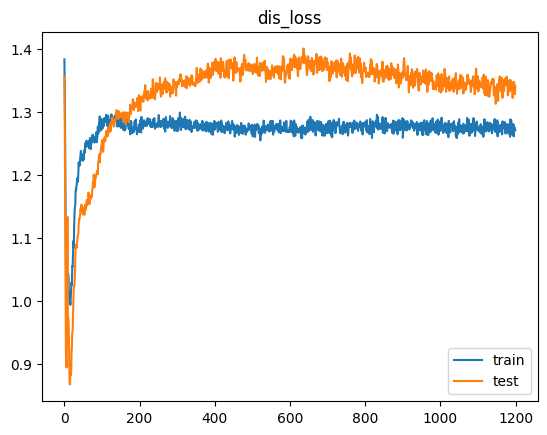

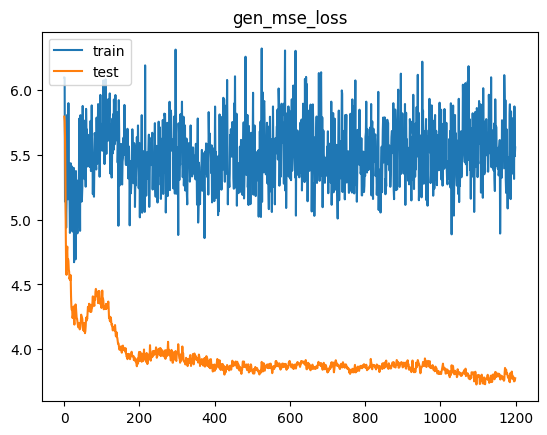

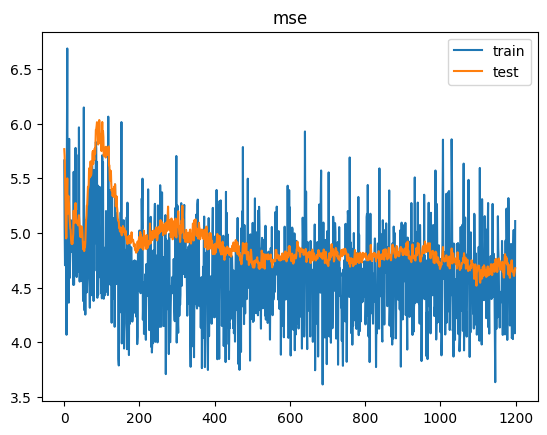

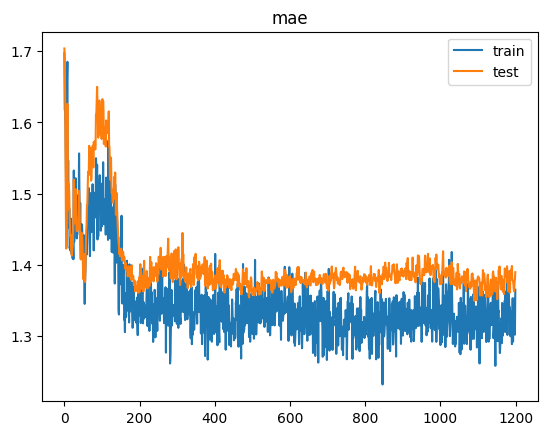

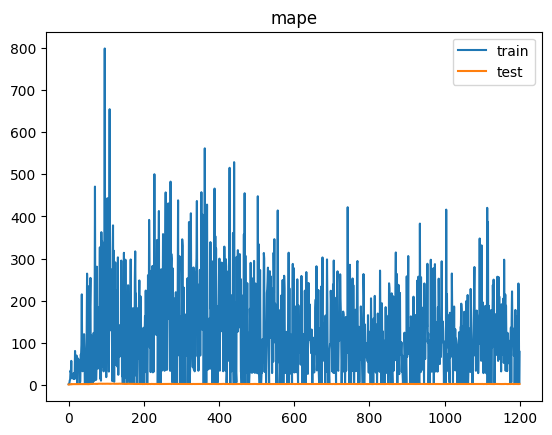

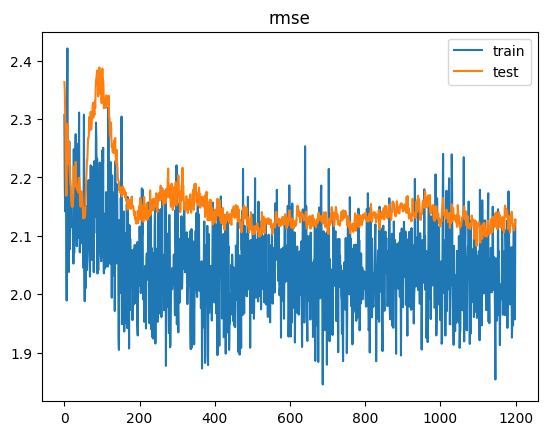

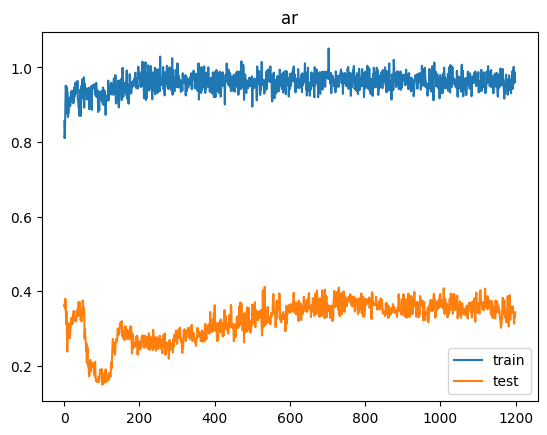

2/2 [==============================] - 0s 3ms/step


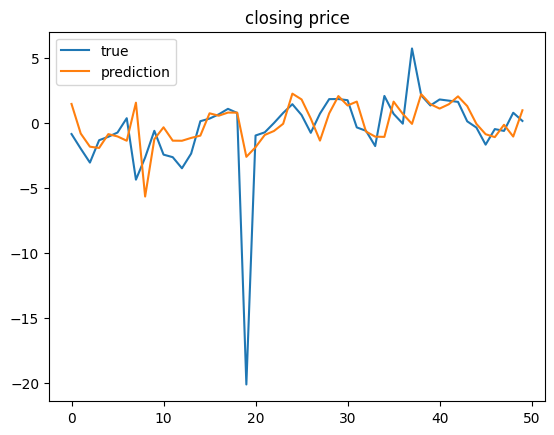

[MSE Baseline] train: 4.913866644436463  test: 4.6881765064049805
Delta time with epochs = 1200: 0:15:56.023753
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_5 (LSTM

Time for epoch 52 is 0.870044469833374 sec Generator Loss: 0.9871172904968262,  Discriminator_loss: 1.2256495952606201
Time for epoch 53 is 0.7909669876098633 sec Generator Loss: 0.9689851999282837,  Discriminator_loss: 1.238855004310608
Time for epoch 54 is 0.8219249248504639 sec Generator Loss: 0.9747668504714966,  Discriminator_loss: 1.2461947202682495
Time for epoch 55 is 0.8421461582183838 sec Generator Loss: 0.945604681968689,  Discriminator_loss: 1.2602614164352417
Time for epoch 56 is 0.8135240077972412 sec Generator Loss: 0.9498860836029053,  Discriminator_loss: 1.2634702920913696
Time for epoch 57 is 0.7944016456604004 sec Generator Loss: 0.9508204460144043,  Discriminator_loss: 1.2551199197769165
Time for epoch 58 is 0.7744243144989014 sec Generator Loss: 0.933371901512146,  Discriminator_loss: 1.2701400518417358
Time for epoch 59 is 0.7856676578521729 sec Generator Loss: 0.9252691268920898,  Discriminator_loss: 1.2744619846343994
Time for epoch 60 is 0.7797093391418457 sec 

Time for epoch 121 is 0.81874680519104 sec Generator Loss: 0.8815391659736633,  Discriminator_loss: 1.3024137020111084
Time for epoch 122 is 0.8184332847595215 sec Generator Loss: 0.8725582361221313,  Discriminator_loss: 1.300437092781067
Time for epoch 123 is 0.8088102340698242 sec Generator Loss: 0.8795754313468933,  Discriminator_loss: 1.3098372220993042
Time for epoch 124 is 0.8417813777923584 sec Generator Loss: 0.8729852437973022,  Discriminator_loss: 1.302610158920288
Time for epoch 125 is 0.8559093475341797 sec Generator Loss: 0.8611637949943542,  Discriminator_loss: 1.3010424375534058
Time for epoch 126 is 0.8078663349151611 sec Generator Loss: 0.8753640055656433,  Discriminator_loss: 1.299034595489502
Time for epoch 127 is 0.8128671646118164 sec Generator Loss: 0.870270848274231,  Discriminator_loss: 1.3009841442108154
Time for epoch 128 is 0.7939372062683105 sec Generator Loss: 0.8661338686943054,  Discriminator_loss: 1.2960118055343628
Time for epoch 129 is 0.77269816398620

Time for epoch 189 is 0.760418176651001 sec Generator Loss: 0.8607684969902039,  Discriminator_loss: 1.303747534751892
Time for epoch 190 is 0.7713460922241211 sec Generator Loss: 0.8549438118934631,  Discriminator_loss: 1.2983434200286865
Time for epoch 191 is 0.7608129978179932 sec Generator Loss: 0.8579858541488647,  Discriminator_loss: 1.311754584312439
Time for epoch 192 is 0.7640969753265381 sec Generator Loss: 0.8599257469177246,  Discriminator_loss: 1.298047661781311
Time for epoch 193 is 0.7602157592773438 sec Generator Loss: 0.8548314571380615,  Discriminator_loss: 1.3071882724761963
Time for epoch 194 is 0.7705843448638916 sec Generator Loss: 0.8549609184265137,  Discriminator_loss: 1.3077144622802734
Time for epoch 195 is 0.766749382019043 sec Generator Loss: 0.8618977069854736,  Discriminator_loss: 1.3022631406784058
Time for epoch 196 is 0.7686774730682373 sec Generator Loss: 0.8778056502342224,  Discriminator_loss: 1.296873688697815
Time for epoch 197 is 0.80595779418945

Time for epoch 257 is 0.7724297046661377 sec Generator Loss: 0.8679303526878357,  Discriminator_loss: 1.300400733947754
Time for epoch 258 is 0.7712154388427734 sec Generator Loss: 0.8652113080024719,  Discriminator_loss: 1.3037004470825195
Time for epoch 259 is 0.7708394527435303 sec Generator Loss: 0.867002010345459,  Discriminator_loss: 1.3029611110687256
Time for epoch 260 is 0.761871337890625 sec Generator Loss: 0.8552286028862,  Discriminator_loss: 1.3012514114379883
Time for epoch 261 is 0.7532451152801514 sec Generator Loss: 0.863111138343811,  Discriminator_loss: 1.2970826625823975
Time for epoch 262 is 0.7578728199005127 sec Generator Loss: 0.8582616448402405,  Discriminator_loss: 1.3102184534072876
Time for epoch 263 is 0.7564136981964111 sec Generator Loss: 0.8600282669067383,  Discriminator_loss: 1.2991998195648193
Time for epoch 264 is 0.7596287727355957 sec Generator Loss: 0.8617067337036133,  Discriminator_loss: 1.3038517236709595
Time for epoch 265 is 0.779166936874389

Time for epoch 326 is 0.7928609848022461 sec Generator Loss: 0.860008180141449,  Discriminator_loss: 1.3089079856872559
Time for epoch 327 is 0.7731852531433105 sec Generator Loss: 0.8531426787376404,  Discriminator_loss: 1.3148199319839478
Time for epoch 328 is 0.7795026302337646 sec Generator Loss: 0.8638917207717896,  Discriminator_loss: 1.3083246946334839
Time for epoch 329 is 0.7574079036712646 sec Generator Loss: 0.8743283152580261,  Discriminator_loss: 1.3030182123184204
Time for epoch 330 is 0.7595615386962891 sec Generator Loss: 0.8691987991333008,  Discriminator_loss: 1.3019661903381348
Time for epoch 331 is 0.758324384689331 sec Generator Loss: 0.8631262183189392,  Discriminator_loss: 1.307346224784851
Time for epoch 332 is 0.7873196601867676 sec Generator Loss: 0.8592785000801086,  Discriminator_loss: 1.309134840965271
Time for epoch 333 is 0.7671487331390381 sec Generator Loss: 0.859355092048645,  Discriminator_loss: 1.3072460889816284
Time for epoch 334 is 0.7689275741577

Time for epoch 394 is 0.8091228008270264 sec Generator Loss: 0.8698557019233704,  Discriminator_loss: 1.305712103843689
Time for epoch 395 is 0.7898004055023193 sec Generator Loss: 0.8694974184036255,  Discriminator_loss: 1.2983800172805786
Time for epoch 396 is 0.7943317890167236 sec Generator Loss: 0.8781666159629822,  Discriminator_loss: 1.2961506843566895
Time for epoch 397 is 0.8152103424072266 sec Generator Loss: 0.8692135810852051,  Discriminator_loss: 1.297946572303772
Time for epoch 398 is 0.806187629699707 sec Generator Loss: 0.8821514844894409,  Discriminator_loss: 1.2885448932647705
Time for epoch 399 is 0.8187668323516846 sec Generator Loss: 0.8680729866027832,  Discriminator_loss: 1.3024431467056274
Time for epoch 400 is 0.8161962032318115 sec Generator Loss: 0.8753260374069214,  Discriminator_loss: 1.2945905923843384
Time for epoch 401 is 0.846228837966919 sec Generator Loss: 0.8749377727508545,  Discriminator_loss: 1.3020228147506714
Time for epoch 402 is 0.867342233657

Time for epoch 462 is 0.7952823638916016 sec Generator Loss: 0.8726869821548462,  Discriminator_loss: 1.2935878038406372
Time for epoch 463 is 0.8028943538665771 sec Generator Loss: 0.8819876313209534,  Discriminator_loss: 1.2975447177886963
Time for epoch 464 is 0.8156535625457764 sec Generator Loss: 0.876498281955719,  Discriminator_loss: 1.2932517528533936
Time for epoch 465 is 0.7947604656219482 sec Generator Loss: 0.879022479057312,  Discriminator_loss: 1.291007399559021
Time for epoch 466 is 0.8044633865356445 sec Generator Loss: 0.8816961050033569,  Discriminator_loss: 1.3012531995773315
Time for epoch 467 is 0.8774328231811523 sec Generator Loss: 0.8885063529014587,  Discriminator_loss: 1.2894247770309448
Time for epoch 468 is 0.8078372478485107 sec Generator Loss: 0.8802711963653564,  Discriminator_loss: 1.2987430095672607
Time for epoch 469 is 0.8048379421234131 sec Generator Loss: 0.883499026298523,  Discriminator_loss: 1.2962576150894165
Time for epoch 470 is 0.796908378601

Time for epoch 531 is 0.7603325843811035 sec Generator Loss: 0.8879864811897278,  Discriminator_loss: 1.2838572263717651
Time for epoch 532 is 0.7581212520599365 sec Generator Loss: 0.8851401209831238,  Discriminator_loss: 1.3006885051727295
Time for epoch 533 is 0.7565865516662598 sec Generator Loss: 0.8736483454704285,  Discriminator_loss: 1.298740029335022
Time for epoch 534 is 0.7602291107177734 sec Generator Loss: 0.8823168873786926,  Discriminator_loss: 1.2951533794403076
Time for epoch 535 is 0.779991626739502 sec Generator Loss: 0.8841651678085327,  Discriminator_loss: 1.2822307348251343
Time for epoch 536 is 0.7970550060272217 sec Generator Loss: 0.8876042366027832,  Discriminator_loss: 1.2976669073104858
Time for epoch 537 is 0.8106546401977539 sec Generator Loss: 0.8844995498657227,  Discriminator_loss: 1.2906527519226074
Time for epoch 538 is 0.7989881038665771 sec Generator Loss: 0.885281503200531,  Discriminator_loss: 1.2925806045532227
Time for epoch 539 is 0.81022572517

Time for epoch 599 is 0.7590551376342773 sec Generator Loss: 0.8982799053192139,  Discriminator_loss: 1.2791060209274292
Time for epoch 600 is 0.7580482959747314 sec Generator Loss: 0.9108807444572449,  Discriminator_loss: 1.2842708826065063
Time for epoch 601 is 0.7699434757232666 sec Generator Loss: 0.8941060900688171,  Discriminator_loss: 1.2887200117111206
Time for epoch 602 is 0.7922542095184326 sec Generator Loss: 0.9046943783760071,  Discriminator_loss: 1.284088373184204
Time for epoch 603 is 0.7682967185974121 sec Generator Loss: 0.8872154951095581,  Discriminator_loss: 1.2920665740966797
Time for epoch 604 is 0.7601218223571777 sec Generator Loss: 0.8925102949142456,  Discriminator_loss: 1.289790391921997
Time for epoch 605 is 0.7582697868347168 sec Generator Loss: 0.8981687426567078,  Discriminator_loss: 1.2843222618103027
Time for epoch 606 is 0.7549922466278076 sec Generator Loss: 0.8870486617088318,  Discriminator_loss: 1.2975091934204102
Time for epoch 607 is 0.7825362682

Time for epoch 667 is 0.7691426277160645 sec Generator Loss: 0.8987364768981934,  Discriminator_loss: 1.2792671918869019
Time for epoch 668 is 0.7605559825897217 sec Generator Loss: 0.9022642970085144,  Discriminator_loss: 1.2853902578353882
Time for epoch 669 is 0.7706279754638672 sec Generator Loss: 0.8998611569404602,  Discriminator_loss: 1.2840287685394287
Time for epoch 670 is 0.7801759243011475 sec Generator Loss: 0.8981195688247681,  Discriminator_loss: 1.2913151979446411
Time for epoch 671 is 0.7678134441375732 sec Generator Loss: 0.895397424697876,  Discriminator_loss: 1.2860468626022339
Time for epoch 672 is 0.7645268440246582 sec Generator Loss: 0.8901090025901794,  Discriminator_loss: 1.2965834140777588
Time for epoch 673 is 0.7559792995452881 sec Generator Loss: 0.901945948600769,  Discriminator_loss: 1.2830616235733032
Time for epoch 674 is 0.7584118843078613 sec Generator Loss: 0.8917278051376343,  Discriminator_loss: 1.281596064567566
Time for epoch 675 is 0.75512433052

Time for epoch 735 is 0.799466609954834 sec Generator Loss: 0.8883129358291626,  Discriminator_loss: 1.284908413887024
Time for epoch 736 is 0.8066682815551758 sec Generator Loss: 0.9048148989677429,  Discriminator_loss: 1.2734321355819702
Time for epoch 737 is 0.8159971237182617 sec Generator Loss: 0.8979722857475281,  Discriminator_loss: 1.2845823764801025
Time for epoch 738 is 0.793133020401001 sec Generator Loss: 0.9112721681594849,  Discriminator_loss: 1.2800745964050293
Time for epoch 739 is 0.8045885562896729 sec Generator Loss: 0.9052422046661377,  Discriminator_loss: 1.2790392637252808
Time for epoch 740 is 0.7755982875823975 sec Generator Loss: 0.9097546339035034,  Discriminator_loss: 1.2806204557418823
Time for epoch 741 is 0.7726798057556152 sec Generator Loss: 0.9020564556121826,  Discriminator_loss: 1.2735116481781006
Time for epoch 742 is 0.7663240432739258 sec Generator Loss: 0.9067413806915283,  Discriminator_loss: 1.280771017074585
Time for epoch 743 is 0.768436670303

Time for epoch 803 is 0.8652234077453613 sec Generator Loss: 0.9100391864776611,  Discriminator_loss: 1.2821359634399414
Time for epoch 804 is 0.8527331352233887 sec Generator Loss: 0.9014831185340881,  Discriminator_loss: 1.278851866722107
Time for epoch 805 is 0.8708937168121338 sec Generator Loss: 0.917159378528595,  Discriminator_loss: 1.2753047943115234
Time for epoch 806 is 0.841550350189209 sec Generator Loss: 0.9001492857933044,  Discriminator_loss: 1.2865959405899048
Time for epoch 807 is 0.8695485591888428 sec Generator Loss: 0.9109154343605042,  Discriminator_loss: 1.2767854928970337
Time for epoch 808 is 0.8168599605560303 sec Generator Loss: 0.9076818227767944,  Discriminator_loss: 1.2842938899993896
Time for epoch 809 is 0.8125674724578857 sec Generator Loss: 0.9049950838088989,  Discriminator_loss: 1.285146713256836
Time for epoch 810 is 0.8079140186309814 sec Generator Loss: 0.9220660924911499,  Discriminator_loss: 1.2642905712127686
Time for epoch 811 is 0.797653913497

Time for epoch 872 is 0.7805221080780029 sec Generator Loss: 0.9155643582344055,  Discriminator_loss: 1.2713083028793335
Time for epoch 873 is 0.8254795074462891 sec Generator Loss: 0.9160822629928589,  Discriminator_loss: 1.2724738121032715
Time for epoch 874 is 0.805492639541626 sec Generator Loss: 0.9286015629768372,  Discriminator_loss: 1.267090082168579
Time for epoch 875 is 0.8216989040374756 sec Generator Loss: 0.918182909488678,  Discriminator_loss: 1.2709535360336304
Time for epoch 876 is 0.8180458545684814 sec Generator Loss: 0.9216165542602539,  Discriminator_loss: 1.275282382965088
Time for epoch 877 is 0.8204643726348877 sec Generator Loss: 0.924389123916626,  Discriminator_loss: 1.2715259790420532
Time for epoch 878 is 0.8404748439788818 sec Generator Loss: 0.915446400642395,  Discriminator_loss: 1.271371841430664
Time for epoch 879 is 0.8467600345611572 sec Generator Loss: 0.9199265241622925,  Discriminator_loss: 1.2612472772598267
Time for epoch 880 is 0.850210428237915

Time for epoch 941 is 0.7780945301055908 sec Generator Loss: 0.9221169352531433,  Discriminator_loss: 1.259661316871643
Time for epoch 942 is 0.7776589393615723 sec Generator Loss: 0.9305227994918823,  Discriminator_loss: 1.275246262550354
Time for epoch 943 is 0.7788136005401611 sec Generator Loss: 0.9321497678756714,  Discriminator_loss: 1.2649726867675781
Time for epoch 944 is 0.7795448303222656 sec Generator Loss: 0.9294275641441345,  Discriminator_loss: 1.2576724290847778
Time for epoch 945 is 0.7670376300811768 sec Generator Loss: 0.9362478852272034,  Discriminator_loss: 1.2744954824447632
Time for epoch 946 is 0.7706477642059326 sec Generator Loss: 0.929460346698761,  Discriminator_loss: 1.2686262130737305
Time for epoch 947 is 0.7901487350463867 sec Generator Loss: 0.9183929562568665,  Discriminator_loss: 1.2754757404327393
Time for epoch 948 is 0.7611019611358643 sec Generator Loss: 0.9132084250450134,  Discriminator_loss: 1.270953893661499
Time for epoch 949 is 0.773357629776

Time for epoch 1009 is 0.7329089641571045 sec Generator Loss: 0.9346921443939209,  Discriminator_loss: 1.2650556564331055
Time for epoch 1010 is 0.7315201759338379 sec Generator Loss: 0.9303421378135681,  Discriminator_loss: 1.2618612051010132
Time for epoch 1011 is 0.7244148254394531 sec Generator Loss: 0.9349242448806763,  Discriminator_loss: 1.247666835784912
Time for epoch 1012 is 0.7323250770568848 sec Generator Loss: 0.9330881237983704,  Discriminator_loss: 1.2691720724105835
Time for epoch 1013 is 0.7357025146484375 sec Generator Loss: 0.9340679049491882,  Discriminator_loss: 1.260562777519226
Time for epoch 1014 is 0.7273461818695068 sec Generator Loss: 0.9361804127693176,  Discriminator_loss: 1.263932228088379
Time for epoch 1015 is 0.7312760353088379 sec Generator Loss: 0.9280166625976562,  Discriminator_loss: 1.2783546447753906
Time for epoch 1016 is 0.7355799674987793 sec Generator Loss: 0.9211640357971191,  Discriminator_loss: 1.2655810117721558
Time for epoch 1017 is 0.73

Time for epoch 1077 is 0.7537021636962891 sec Generator Loss: 0.9332859516143799,  Discriminator_loss: 1.2635005712509155
Time for epoch 1078 is 0.7536275386810303 sec Generator Loss: 0.9277491569519043,  Discriminator_loss: 1.2662421464920044
Time for epoch 1079 is 0.7533504962921143 sec Generator Loss: 0.9402623772621155,  Discriminator_loss: 1.2597105503082275
Time for epoch 1080 is 0.7484798431396484 sec Generator Loss: 0.9283093810081482,  Discriminator_loss: 1.2684540748596191
Time for epoch 1081 is 0.7467663288116455 sec Generator Loss: 0.9307824969291687,  Discriminator_loss: 1.2612419128417969
Time for epoch 1082 is 0.7570013999938965 sec Generator Loss: 0.9298428893089294,  Discriminator_loss: 1.27023184299469
Time for epoch 1083 is 0.7616708278656006 sec Generator Loss: 0.932978630065918,  Discriminator_loss: 1.2679133415222168
Time for epoch 1084 is 0.7494065761566162 sec Generator Loss: 0.9559761881828308,  Discriminator_loss: 1.249202013015747
Time for epoch 1085 is 0.773

Time for epoch 1145 is 0.7513735294342041 sec Generator Loss: 0.9354695677757263,  Discriminator_loss: 1.2688708305358887
Time for epoch 1146 is 0.7670390605926514 sec Generator Loss: 0.9359229803085327,  Discriminator_loss: 1.2578916549682617
Time for epoch 1147 is 0.7610435485839844 sec Generator Loss: 0.9247454404830933,  Discriminator_loss: 1.2716883420944214
Time for epoch 1148 is 0.7595224380493164 sec Generator Loss: 0.9343615770339966,  Discriminator_loss: 1.269890546798706
Time for epoch 1149 is 0.7491514682769775 sec Generator Loss: 0.9310427308082581,  Discriminator_loss: 1.266486406326294
Time for epoch 1150 is 0.7573692798614502 sec Generator Loss: 0.9279617071151733,  Discriminator_loss: 1.2572007179260254
Time for epoch 1151 is 0.762873649597168 sec Generator Loss: 0.9391488432884216,  Discriminator_loss: 1.2654792070388794
Time for epoch 1152 is 0.7610523700714111 sec Generator Loss: 0.9287585020065308,  Discriminator_loss: 1.2639201879501343
Time for epoch 1153 is 0.76

Time for epoch 1213 is 0.7365708351135254 sec Generator Loss: 0.9351032972335815,  Discriminator_loss: 1.264395833015442
Time for epoch 1214 is 0.7462589740753174 sec Generator Loss: 0.9366965889930725,  Discriminator_loss: 1.2636386156082153
Time for epoch 1215 is 0.760333776473999 sec Generator Loss: 0.9216211438179016,  Discriminator_loss: 1.2685190439224243
Time for epoch 1216 is 0.7450151443481445 sec Generator Loss: 0.9363951086997986,  Discriminator_loss: 1.2653850317001343
Time for epoch 1217 is 0.7444760799407959 sec Generator Loss: 0.9312512874603271,  Discriminator_loss: 1.2636862993240356
Time for epoch 1218 is 0.7579524517059326 sec Generator Loss: 0.9239981770515442,  Discriminator_loss: 1.2700921297073364
Time for epoch 1219 is 0.7484610080718994 sec Generator Loss: 0.919025182723999,  Discriminator_loss: 1.2676318883895874
Time for epoch 1220 is 0.7601726055145264 sec Generator Loss: 0.9257603883743286,  Discriminator_loss: 1.262492299079895
Time for epoch 1221 is 0.747

Time for epoch 1281 is 0.7588396072387695 sec Generator Loss: 0.9389684200286865,  Discriminator_loss: 1.2620259523391724
Time for epoch 1282 is 0.7410273551940918 sec Generator Loss: 0.9358968734741211,  Discriminator_loss: 1.2728710174560547
Time for epoch 1283 is 0.7268297672271729 sec Generator Loss: 0.9397830963134766,  Discriminator_loss: 1.260887861251831
Time for epoch 1284 is 0.7283546924591064 sec Generator Loss: 0.9358769655227661,  Discriminator_loss: 1.2750273942947388
Time for epoch 1285 is 0.730541467666626 sec Generator Loss: 0.9328996539115906,  Discriminator_loss: 1.2607197761535645
Time for epoch 1286 is 0.7396490573883057 sec Generator Loss: 0.9351324439048767,  Discriminator_loss: 1.2562187910079956
Time for epoch 1287 is 0.7305021286010742 sec Generator Loss: 0.928666353225708,  Discriminator_loss: 1.2611802816390991
Time for epoch 1288 is 0.7397468090057373 sec Generator Loss: 0.9339523315429688,  Discriminator_loss: 1.279902458190918
Time for epoch 1289 is 0.739

Time for epoch 1349 is 0.7524845600128174 sec Generator Loss: 0.9311583042144775,  Discriminator_loss: 1.257908821105957
Time for epoch 1350 is 0.7330429553985596 sec Generator Loss: 0.9335536956787109,  Discriminator_loss: 1.2687468528747559
Time for epoch 1351 is 0.7380330562591553 sec Generator Loss: 0.9297806620597839,  Discriminator_loss: 1.2603614330291748
Time for epoch 1352 is 0.7573707103729248 sec Generator Loss: 0.9318348169326782,  Discriminator_loss: 1.2695635557174683
Time for epoch 1353 is 0.7594952583312988 sec Generator Loss: 0.9238059520721436,  Discriminator_loss: 1.2677466869354248
Time for epoch 1354 is 0.7510514259338379 sec Generator Loss: 0.9237971305847168,  Discriminator_loss: 1.2667075395584106
Time for epoch 1355 is 0.7620842456817627 sec Generator Loss: 0.933574378490448,  Discriminator_loss: 1.2678234577178955
Time for epoch 1356 is 0.7679762840270996 sec Generator Loss: 0.9371952414512634,  Discriminator_loss: 1.2623544931411743
Time for epoch 1357 is 0.7

Time for epoch 1417 is 0.7427403926849365 sec Generator Loss: 0.9347110390663147,  Discriminator_loss: 1.262524962425232
Time for epoch 1418 is 0.7524983882904053 sec Generator Loss: 0.9524596929550171,  Discriminator_loss: 1.245147705078125
Time for epoch 1419 is 0.7332882881164551 sec Generator Loss: 0.9426988959312439,  Discriminator_loss: 1.264953851699829
Time for epoch 1420 is 0.74208664894104 sec Generator Loss: 0.9348850250244141,  Discriminator_loss: 1.2717351913452148
Time for epoch 1421 is 0.7465181350708008 sec Generator Loss: 0.9365628361701965,  Discriminator_loss: 1.2716467380523682
Time for epoch 1422 is 0.7391674518585205 sec Generator Loss: 0.9433586597442627,  Discriminator_loss: 1.2537161111831665
Time for epoch 1423 is 0.7418131828308105 sec Generator Loss: 0.9366356134414673,  Discriminator_loss: 1.263351321220398
Time for epoch 1424 is 0.7370548248291016 sec Generator Loss: 0.9446430206298828,  Discriminator_loss: 1.2486406564712524
Time for epoch 1425 is 0.73212

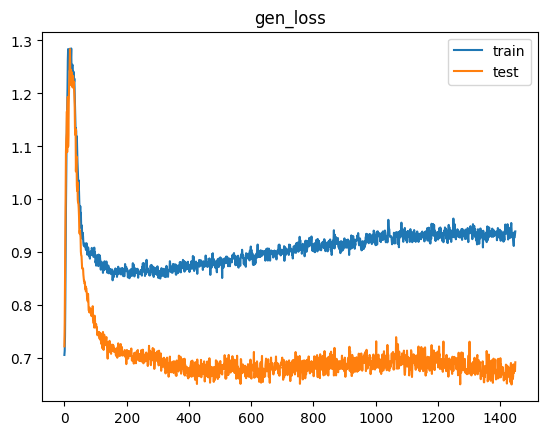

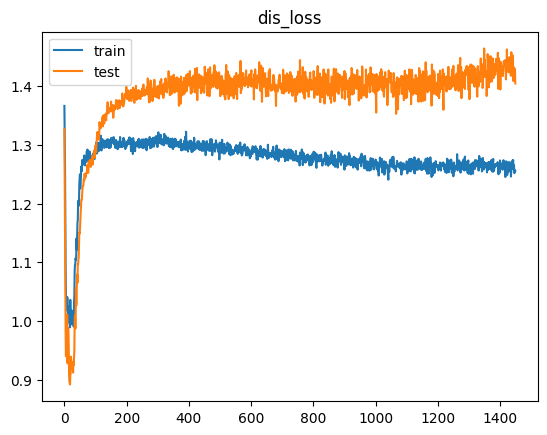

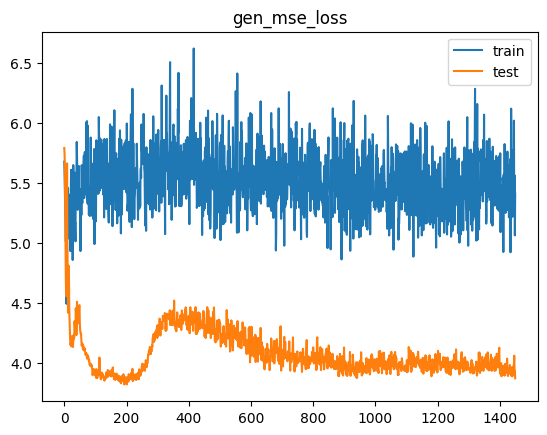

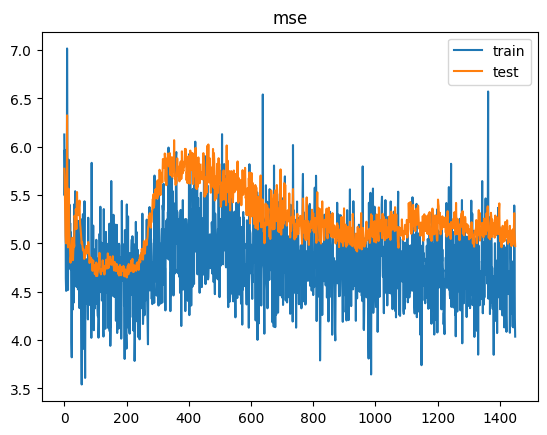

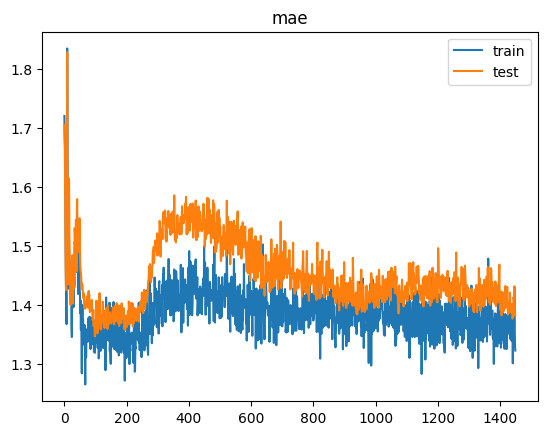

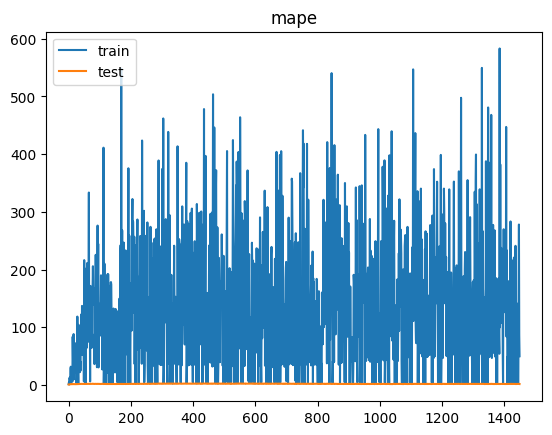

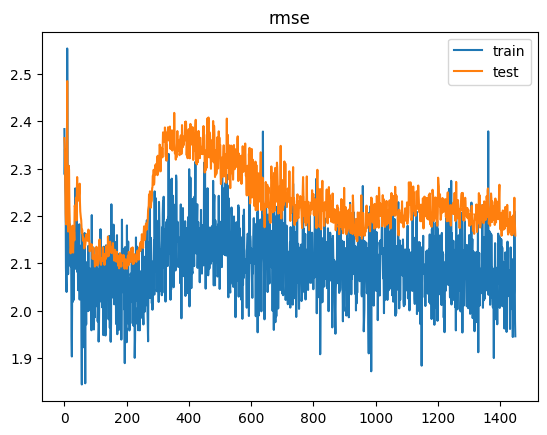

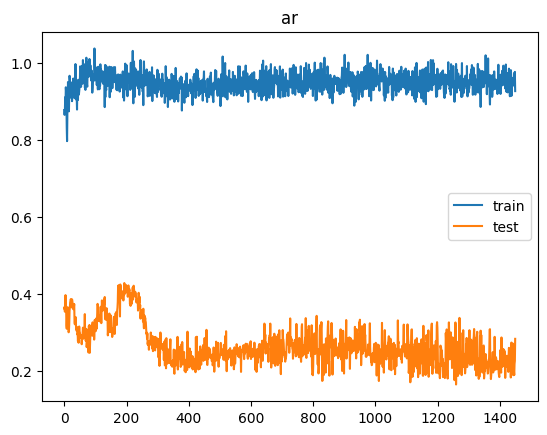

2/2 [==============================] - 0s 4ms/step


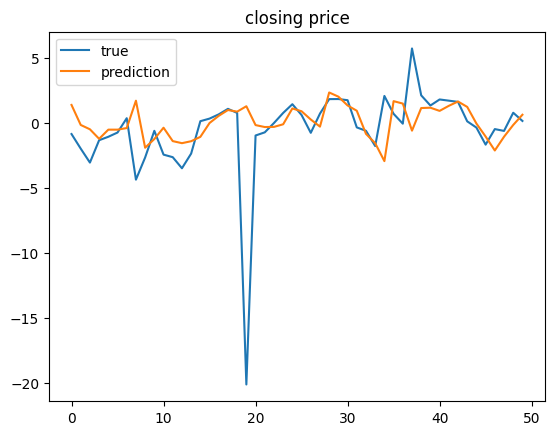

[MSE Baseline] train: 4.57740769193484  test: 4.6881765064049805
Delta time with epochs = 1450: 0:19:00.562478
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 10)             720       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_7 (LSTM)

Time for epoch 52 is 0.7725436687469482 sec Generator Loss: 1.0964789390563965,  Discriminator_loss: 1.1438627243041992
Time for epoch 53 is 0.7665376663208008 sec Generator Loss: 1.0863009691238403,  Discriminator_loss: 1.1368709802627563
Time for epoch 54 is 0.7707476615905762 sec Generator Loss: 1.0615627765655518,  Discriminator_loss: 1.165876865386963
Time for epoch 55 is 0.751488447189331 sec Generator Loss: 1.069278359413147,  Discriminator_loss: 1.1562775373458862
Time for epoch 56 is 0.7479064464569092 sec Generator Loss: 1.067562222480774,  Discriminator_loss: 1.1721633672714233
Time for epoch 57 is 0.7476916313171387 sec Generator Loss: 1.0586740970611572,  Discriminator_loss: 1.1744617223739624
Time for epoch 58 is 0.746406078338623 sec Generator Loss: 1.0472110509872437,  Discriminator_loss: 1.1820495128631592
Time for epoch 59 is 0.7518625259399414 sec Generator Loss: 1.031977891921997,  Discriminator_loss: 1.2022074460983276
Time for epoch 60 is 0.7531261444091797 sec Ge

Time for epoch 121 is 0.7653226852416992 sec Generator Loss: 0.9431928396224976,  Discriminator_loss: 1.2579071521759033
Time for epoch 122 is 0.7785129547119141 sec Generator Loss: 0.9538912177085876,  Discriminator_loss: 1.2492069005966187
Time for epoch 123 is 0.7692298889160156 sec Generator Loss: 0.9539828300476074,  Discriminator_loss: 1.2571269273757935
Time for epoch 124 is 0.7757081985473633 sec Generator Loss: 0.9629088044166565,  Discriminator_loss: 1.2550967931747437
Time for epoch 125 is 0.7668685913085938 sec Generator Loss: 0.9457495212554932,  Discriminator_loss: 1.260722041130066
Time for epoch 126 is 0.7543113231658936 sec Generator Loss: 0.945370614528656,  Discriminator_loss: 1.2626266479492188
Time for epoch 127 is 0.7786195278167725 sec Generator Loss: 0.9379115104675293,  Discriminator_loss: 1.258005142211914
Time for epoch 128 is 0.7595877647399902 sec Generator Loss: 0.9499291181564331,  Discriminator_loss: 1.2619742155075073
Time for epoch 129 is 0.77444839477

Time for epoch 189 is 0.7733073234558105 sec Generator Loss: 0.9160321354866028,  Discriminator_loss: 1.2675843238830566
Time for epoch 190 is 0.762352466583252 sec Generator Loss: 0.9247105717658997,  Discriminator_loss: 1.2744781970977783
Time for epoch 191 is 0.7737095355987549 sec Generator Loss: 0.9137409925460815,  Discriminator_loss: 1.2860524654388428
Time for epoch 192 is 0.776968240737915 sec Generator Loss: 0.9199516773223877,  Discriminator_loss: 1.2543258666992188
Time for epoch 193 is 0.7702081203460693 sec Generator Loss: 0.9189832210540771,  Discriminator_loss: 1.2722527980804443
Time for epoch 194 is 0.7687852382659912 sec Generator Loss: 0.9173434376716614,  Discriminator_loss: 1.2672842741012573
Time for epoch 195 is 0.7624044418334961 sec Generator Loss: 0.9114000797271729,  Discriminator_loss: 1.2771514654159546
Time for epoch 196 is 0.7857153415679932 sec Generator Loss: 0.9139134883880615,  Discriminator_loss: 1.272424340248108
Time for epoch 197 is 0.77074027061

Time for epoch 258 is 0.7565586566925049 sec Generator Loss: 0.9025307297706604,  Discriminator_loss: 1.2833783626556396
Time for epoch 259 is 0.7468061447143555 sec Generator Loss: 0.8937457799911499,  Discriminator_loss: 1.287840723991394
Time for epoch 260 is 0.7628583908081055 sec Generator Loss: 0.898269534111023,  Discriminator_loss: 1.2870841026306152
Time for epoch 261 is 0.7480800151824951 sec Generator Loss: 0.8983597755432129,  Discriminator_loss: 1.2773462533950806
Time for epoch 262 is 0.7415866851806641 sec Generator Loss: 0.8884167671203613,  Discriminator_loss: 1.289250135421753
Time for epoch 263 is 0.7433228492736816 sec Generator Loss: 0.8915607333183289,  Discriminator_loss: 1.2900989055633545
Time for epoch 264 is 0.748488187789917 sec Generator Loss: 0.9002645015716553,  Discriminator_loss: 1.274775743484497
Time for epoch 265 is 0.7666637897491455 sec Generator Loss: 0.8986673951148987,  Discriminator_loss: 1.2749091386795044
Time for epoch 266 is 0.7560582160949

Time for epoch 326 is 0.750126838684082 sec Generator Loss: 0.9017572402954102,  Discriminator_loss: 1.2741256952285767
Time for epoch 327 is 0.7554059028625488 sec Generator Loss: 0.9037140011787415,  Discriminator_loss: 1.2759944200515747
Time for epoch 328 is 0.7512867450714111 sec Generator Loss: 0.8936655521392822,  Discriminator_loss: 1.279536485671997
Time for epoch 329 is 0.7543878555297852 sec Generator Loss: 0.8988656997680664,  Discriminator_loss: 1.2767791748046875
Time for epoch 330 is 0.7510514259338379 sec Generator Loss: 0.911611020565033,  Discriminator_loss: 1.272521734237671
Time for epoch 331 is 0.7501699924468994 sec Generator Loss: 0.907791256904602,  Discriminator_loss: 1.2762608528137207
Time for epoch 332 is 0.751107931137085 sec Generator Loss: 0.8908155560493469,  Discriminator_loss: 1.2848159074783325
Time for epoch 333 is 0.7525780200958252 sec Generator Loss: 0.9132171273231506,  Discriminator_loss: 1.271897554397583
Time for epoch 334 is 0.753481626510620

Time for epoch 394 is 0.7734696865081787 sec Generator Loss: 0.9194127321243286,  Discriminator_loss: 1.2677041292190552
Time for epoch 395 is 0.7495946884155273 sec Generator Loss: 0.9201086163520813,  Discriminator_loss: 1.2849396467208862
Time for epoch 396 is 0.7707443237304688 sec Generator Loss: 0.9069069623947144,  Discriminator_loss: 1.2737298011779785
Time for epoch 397 is 0.7526001930236816 sec Generator Loss: 0.9004724025726318,  Discriminator_loss: 1.275081753730774
Time for epoch 398 is 0.7506775856018066 sec Generator Loss: 0.9152039885520935,  Discriminator_loss: 1.2721408605575562
Time for epoch 399 is 0.7496383190155029 sec Generator Loss: 0.9067307114601135,  Discriminator_loss: 1.2665860652923584
Time for epoch 400 is 0.7701709270477295 sec Generator Loss: 0.9073799848556519,  Discriminator_loss: 1.285354495048523
Time for epoch 401 is 0.7550439834594727 sec Generator Loss: 0.898597776889801,  Discriminator_loss: 1.2808607816696167
Time for epoch 402 is 0.75786995887

Time for epoch 463 is 0.7885622978210449 sec Generator Loss: 0.9110032320022583,  Discriminator_loss: 1.2699424028396606
Time for epoch 464 is 0.7873620986938477 sec Generator Loss: 0.9149205088615417,  Discriminator_loss: 1.2680991888046265
Time for epoch 465 is 0.8005690574645996 sec Generator Loss: 0.9090442061424255,  Discriminator_loss: 1.2636349201202393
Time for epoch 466 is 0.7752053737640381 sec Generator Loss: 0.9189096093177795,  Discriminator_loss: 1.2663592100143433
Time for epoch 467 is 0.7752699851989746 sec Generator Loss: 0.9196515679359436,  Discriminator_loss: 1.2669804096221924
Time for epoch 468 is 0.7818987369537354 sec Generator Loss: 0.9196511507034302,  Discriminator_loss: 1.2732619047164917
Time for epoch 469 is 0.8085124492645264 sec Generator Loss: 0.9200233221054077,  Discriminator_loss: 1.268302083015442
Time for epoch 470 is 0.7826087474822998 sec Generator Loss: 0.9137234687805176,  Discriminator_loss: 1.2655576467514038
Time for epoch 471 is 0.796133041

Time for epoch 531 is 0.7881286144256592 sec Generator Loss: 0.9183514714241028,  Discriminator_loss: 1.26112699508667
Time for epoch 532 is 0.8065800666809082 sec Generator Loss: 0.9287395477294922,  Discriminator_loss: 1.2638593912124634
Time for epoch 533 is 0.7816221714019775 sec Generator Loss: 0.9172768592834473,  Discriminator_loss: 1.2596545219421387
Time for epoch 534 is 0.7838842868804932 sec Generator Loss: 0.919203519821167,  Discriminator_loss: 1.263649344444275
Time for epoch 535 is 0.7763769626617432 sec Generator Loss: 0.9192381501197815,  Discriminator_loss: 1.2708992958068848
Time for epoch 536 is 0.7934350967407227 sec Generator Loss: 0.924217700958252,  Discriminator_loss: 1.2596617937088013
Time for epoch 537 is 0.7956771850585938 sec Generator Loss: 0.9200350642204285,  Discriminator_loss: 1.2582802772521973
Time for epoch 538 is 0.8056340217590332 sec Generator Loss: 0.9191247820854187,  Discriminator_loss: 1.2664766311645508
Time for epoch 539 is 0.7953834533691

Time for epoch 600 is 0.8422806262969971 sec Generator Loss: 0.9261229634284973,  Discriminator_loss: 1.2621259689331055
Time for epoch 601 is 0.8291804790496826 sec Generator Loss: 0.9118664860725403,  Discriminator_loss: 1.263870120048523
Time for epoch 602 is 0.8082172870635986 sec Generator Loss: 0.9144200682640076,  Discriminator_loss: 1.2606619596481323
Time for epoch 603 is 0.7884430885314941 sec Generator Loss: 0.9220842719078064,  Discriminator_loss: 1.2554837465286255
Time for epoch 604 is 0.7926895618438721 sec Generator Loss: 0.9165474772453308,  Discriminator_loss: 1.2601969242095947
Time for epoch 605 is 0.7956893444061279 sec Generator Loss: 0.9192380905151367,  Discriminator_loss: 1.2593967914581299
Time for epoch 606 is 0.7868812084197998 sec Generator Loss: 0.9275974035263062,  Discriminator_loss: 1.2524267435073853
Time for epoch 607 is 0.842226505279541 sec Generator Loss: 0.9189633727073669,  Discriminator_loss: 1.2716772556304932
Time for epoch 608 is 0.7941203117

Time for epoch 668 is 0.7733240127563477 sec Generator Loss: 0.9323903322219849,  Discriminator_loss: 1.2615230083465576
Time for epoch 669 is 0.7714440822601318 sec Generator Loss: 0.9310251474380493,  Discriminator_loss: 1.2631001472473145
Time for epoch 670 is 0.7670197486877441 sec Generator Loss: 0.9310116767883301,  Discriminator_loss: 1.246195673942566
Time for epoch 671 is 0.8035745620727539 sec Generator Loss: 0.915515661239624,  Discriminator_loss: 1.272220492362976
Time for epoch 672 is 0.793748140335083 sec Generator Loss: 0.9249414205551147,  Discriminator_loss: 1.260026216506958
Time for epoch 673 is 0.7979485988616943 sec Generator Loss: 0.926771342754364,  Discriminator_loss: 1.2631381750106812
Time for epoch 674 is 0.7957553863525391 sec Generator Loss: 0.9314742088317871,  Discriminator_loss: 1.2555631399154663
Time for epoch 675 is 0.8017656803131104 sec Generator Loss: 0.9307542443275452,  Discriminator_loss: 1.2559484243392944
Time for epoch 676 is 0.79770994186401

Time for epoch 737 is 0.7780885696411133 sec Generator Loss: 0.9335392117500305,  Discriminator_loss: 1.263500452041626
Time for epoch 738 is 0.7622628211975098 sec Generator Loss: 0.9277511239051819,  Discriminator_loss: 1.2552114725112915
Time for epoch 739 is 0.770366907119751 sec Generator Loss: 0.9131034016609192,  Discriminator_loss: 1.270797848701477
Time for epoch 740 is 0.7603635787963867 sec Generator Loss: 0.9166847467422485,  Discriminator_loss: 1.2589056491851807
Time for epoch 741 is 0.7626655101776123 sec Generator Loss: 0.9390027523040771,  Discriminator_loss: 1.2491215467453003
Time for epoch 742 is 0.764509916305542 sec Generator Loss: 0.9361340403556824,  Discriminator_loss: 1.2502505779266357
Time for epoch 743 is 0.7789440155029297 sec Generator Loss: 0.9281344413757324,  Discriminator_loss: 1.2520251274108887
Time for epoch 744 is 0.7632761001586914 sec Generator Loss: 0.9268088936805725,  Discriminator_loss: 1.2658311128616333
Time for epoch 745 is 0.766784667968

Time for epoch 806 is 0.7764527797698975 sec Generator Loss: 0.9244565367698669,  Discriminator_loss: 1.254218578338623
Time for epoch 807 is 0.7680327892303467 sec Generator Loss: 0.9274439811706543,  Discriminator_loss: 1.2599983215332031
Time for epoch 808 is 0.7794895172119141 sec Generator Loss: 0.9387879967689514,  Discriminator_loss: 1.2458148002624512
Time for epoch 809 is 0.7795093059539795 sec Generator Loss: 0.9482173323631287,  Discriminator_loss: 1.241575837135315
Time for epoch 810 is 0.775054931640625 sec Generator Loss: 0.9218196272850037,  Discriminator_loss: 1.2586092948913574
Time for epoch 811 is 0.7828774452209473 sec Generator Loss: 0.9324067831039429,  Discriminator_loss: 1.2505120038986206
Time for epoch 812 is 0.7778427600860596 sec Generator Loss: 0.9258063435554504,  Discriminator_loss: 1.2594395875930786
Time for epoch 813 is 0.7723205089569092 sec Generator Loss: 0.9229703545570374,  Discriminator_loss: 1.2565151453018188
Time for epoch 814 is 0.76688146591

Time for epoch 874 is 0.8004066944122314 sec Generator Loss: 0.9341462850570679,  Discriminator_loss: 1.255284070968628
Time for epoch 875 is 0.8432881832122803 sec Generator Loss: 0.9378983974456787,  Discriminator_loss: 1.252114176750183
Time for epoch 876 is 0.8116636276245117 sec Generator Loss: 0.9337854981422424,  Discriminator_loss: 1.2538577318191528
Time for epoch 877 is 0.8015646934509277 sec Generator Loss: 0.9396981000900269,  Discriminator_loss: 1.2517222166061401
Time for epoch 878 is 0.7988455295562744 sec Generator Loss: 0.935438871383667,  Discriminator_loss: 1.248583436012268
Time for epoch 879 is 0.7973966598510742 sec Generator Loss: 0.9329639077186584,  Discriminator_loss: 1.2515677213668823
Time for epoch 880 is 0.803626298904419 sec Generator Loss: 0.9387788772583008,  Discriminator_loss: 1.258482575416565
Time for epoch 881 is 0.8166043758392334 sec Generator Loss: 0.922572135925293,  Discriminator_loss: 1.2619749307632446
Time for epoch 882 is 0.801535129547119

Time for epoch 943 is 0.8024628162384033 sec Generator Loss: 0.9426278471946716,  Discriminator_loss: 1.2549433708190918
Time for epoch 944 is 0.8085711002349854 sec Generator Loss: 0.9432944655418396,  Discriminator_loss: 1.2552053928375244
Time for epoch 945 is 0.8080520629882812 sec Generator Loss: 0.9321091175079346,  Discriminator_loss: 1.2520233392715454
Time for epoch 946 is 0.8028144836425781 sec Generator Loss: 0.9345090389251709,  Discriminator_loss: 1.2633050680160522
Time for epoch 947 is 0.792025089263916 sec Generator Loss: 0.9364748597145081,  Discriminator_loss: 1.2403154373168945
Time for epoch 948 is 0.7901556491851807 sec Generator Loss: 0.9382403492927551,  Discriminator_loss: 1.2429057359695435
Time for epoch 949 is 0.7849142551422119 sec Generator Loss: 0.9293962121009827,  Discriminator_loss: 1.2571579217910767
Time for epoch 950 is 2.3262765407562256 sec Generator Loss: 0.9356781244277954,  Discriminator_loss: 1.2523196935653687
Time for epoch 951 is 0.813451051

Time for epoch 1011 is 0.7740936279296875 sec Generator Loss: 0.9386138319969177,  Discriminator_loss: 1.2559587955474854
Time for epoch 1012 is 0.7759201526641846 sec Generator Loss: 0.9383676648139954,  Discriminator_loss: 1.2549748420715332
Time for epoch 1013 is 0.777595043182373 sec Generator Loss: 0.9413215517997742,  Discriminator_loss: 1.2425847053527832
Time for epoch 1014 is 0.7771475315093994 sec Generator Loss: 0.9391354918479919,  Discriminator_loss: 1.25580632686615
Time for epoch 1015 is 0.7785348892211914 sec Generator Loss: 0.9459707736968994,  Discriminator_loss: 1.2430801391601562
Time for epoch 1016 is 0.7708501815795898 sec Generator Loss: 0.9361898899078369,  Discriminator_loss: 1.2548638582229614
Time for epoch 1017 is 0.7774899005889893 sec Generator Loss: 0.9347849488258362,  Discriminator_loss: 1.2577030658721924
Time for epoch 1018 is 0.7839560508728027 sec Generator Loss: 0.9431390762329102,  Discriminator_loss: 1.2456952333450317
Time for epoch 1019 is 0.86

Time for epoch 1079 is 0.7788240909576416 sec Generator Loss: 0.9441023468971252,  Discriminator_loss: 1.235899567604065
Time for epoch 1080 is 0.7809247970581055 sec Generator Loss: 0.9458920955657959,  Discriminator_loss: 1.2544653415679932
Time for epoch 1081 is 0.7930514812469482 sec Generator Loss: 0.9397178888320923,  Discriminator_loss: 1.2670307159423828
Time for epoch 1082 is 0.7933518886566162 sec Generator Loss: 0.9400651454925537,  Discriminator_loss: 1.2470459938049316
Time for epoch 1083 is 0.7810888290405273 sec Generator Loss: 0.9468302726745605,  Discriminator_loss: 1.2612611055374146
Time for epoch 1084 is 0.7779514789581299 sec Generator Loss: 0.9473575949668884,  Discriminator_loss: 1.2500356435775757
Time for epoch 1085 is 0.7806401252746582 sec Generator Loss: 0.9388682842254639,  Discriminator_loss: 1.2589950561523438
Time for epoch 1086 is 0.7772343158721924 sec Generator Loss: 0.9342663884162903,  Discriminator_loss: 1.2523738145828247
Time for epoch 1087 is 0.

Time for epoch 1147 is 0.7865636348724365 sec Generator Loss: 0.9471612572669983,  Discriminator_loss: 1.2525641918182373
Time for epoch 1148 is 0.7899928092956543 sec Generator Loss: 0.9358641505241394,  Discriminator_loss: 1.2607933282852173
Time for epoch 1149 is 0.7903568744659424 sec Generator Loss: 0.9280393123626709,  Discriminator_loss: 1.263014793395996
Time for epoch 1150 is 0.7820661067962646 sec Generator Loss: 0.9395350217819214,  Discriminator_loss: 1.2506012916564941
Time for epoch 1151 is 0.7863030433654785 sec Generator Loss: 0.9362000823020935,  Discriminator_loss: 1.2610384225845337
Time for epoch 1152 is 0.7863171100616455 sec Generator Loss: 0.9361987113952637,  Discriminator_loss: 1.267671823501587
Time for epoch 1153 is 0.7857306003570557 sec Generator Loss: 0.9400662183761597,  Discriminator_loss: 1.267886996269226
Time for epoch 1154 is 0.7950036525726318 sec Generator Loss: 0.9423028826713562,  Discriminator_loss: 1.2500159740447998
Time for epoch 1155 is 0.85

Time for epoch 1215 is 0.7837891578674316 sec Generator Loss: 0.9397026300430298,  Discriminator_loss: 1.2567623853683472
Time for epoch 1216 is 0.7930641174316406 sec Generator Loss: 0.9260947704315186,  Discriminator_loss: 1.2702534198760986
Time for epoch 1217 is 0.7800216674804688 sec Generator Loss: 0.9323770999908447,  Discriminator_loss: 1.2718425989151
Time for epoch 1218 is 0.785142183303833 sec Generator Loss: 0.9214636087417603,  Discriminator_loss: 1.2693064212799072
Time for epoch 1219 is 0.7889878749847412 sec Generator Loss: 0.9307606220245361,  Discriminator_loss: 1.2615501880645752
Time for epoch 1220 is 0.782726526260376 sec Generator Loss: 0.9303717613220215,  Discriminator_loss: 1.258222222328186
Time for epoch 1221 is 0.7855837345123291 sec Generator Loss: 0.932944655418396,  Discriminator_loss: 1.2678594589233398
Time for epoch 1222 is 0.7873513698577881 sec Generator Loss: 0.929469645023346,  Discriminator_loss: 1.262778878211975
Time for epoch 1223 is 0.80931329

Time for epoch 1283 is 0.8133788108825684 sec Generator Loss: 0.9137391448020935,  Discriminator_loss: 1.273537039756775
Time for epoch 1284 is 0.8309237957000732 sec Generator Loss: 0.9203054308891296,  Discriminator_loss: 1.2681442499160767
Time for epoch 1285 is 0.8549716472625732 sec Generator Loss: 0.9404128789901733,  Discriminator_loss: 1.2545509338378906
Time for epoch 1286 is 0.8290271759033203 sec Generator Loss: 0.9501911997795105,  Discriminator_loss: 1.2527285814285278
Time for epoch 1287 is 0.8268887996673584 sec Generator Loss: 0.9349545836448669,  Discriminator_loss: 1.2579959630966187
Time for epoch 1288 is 0.8242189884185791 sec Generator Loss: 0.9361199736595154,  Discriminator_loss: 1.2674554586410522
Time for epoch 1289 is 0.7993602752685547 sec Generator Loss: 0.9372346997261047,  Discriminator_loss: 1.2700361013412476
Time for epoch 1290 is 0.835655689239502 sec Generator Loss: 0.9311051964759827,  Discriminator_loss: 1.2666852474212646
Time for epoch 1291 is 0.8

Time for epoch 1351 is 0.8635342121124268 sec Generator Loss: 0.9201268553733826,  Discriminator_loss: 1.2635340690612793
Time for epoch 1352 is 0.8358700275421143 sec Generator Loss: 0.9404553771018982,  Discriminator_loss: 1.2584447860717773
Time for epoch 1353 is 0.8172416687011719 sec Generator Loss: 0.9187553524971008,  Discriminator_loss: 1.2735649347305298
Time for epoch 1354 is 0.8407747745513916 sec Generator Loss: 0.9296952486038208,  Discriminator_loss: 1.2637606859207153
Time for epoch 1355 is 0.8192734718322754 sec Generator Loss: 0.9401808381080627,  Discriminator_loss: 1.2592015266418457
Time for epoch 1356 is 0.8182003498077393 sec Generator Loss: 0.9312243461608887,  Discriminator_loss: 1.267748236656189
Time for epoch 1357 is 0.8255565166473389 sec Generator Loss: 0.932030200958252,  Discriminator_loss: 1.2701656818389893
Time for epoch 1358 is 0.8178563117980957 sec Generator Loss: 0.9253387451171875,  Discriminator_loss: 1.273409366607666
Time for epoch 1359 is 0.83

Time for epoch 1419 is 0.8372690677642822 sec Generator Loss: 0.9349260330200195,  Discriminator_loss: 1.2568856477737427
Time for epoch 1420 is 0.8454129695892334 sec Generator Loss: 0.929526686668396,  Discriminator_loss: 1.2741308212280273
Time for epoch 1421 is 0.8572921752929688 sec Generator Loss: 0.9207566380500793,  Discriminator_loss: 1.2734955549240112
Time for epoch 1422 is 0.862018346786499 sec Generator Loss: 0.9270905256271362,  Discriminator_loss: 1.2730672359466553
Time for epoch 1423 is 0.8685271739959717 sec Generator Loss: 0.9262470006942749,  Discriminator_loss: 1.2735158205032349
Time for epoch 1424 is 0.8864328861236572 sec Generator Loss: 0.9199455976486206,  Discriminator_loss: 1.2747098207473755
Time for epoch 1425 is 0.8355808258056641 sec Generator Loss: 0.928014874458313,  Discriminator_loss: 1.2717244625091553
Time for epoch 1426 is 0.8209390640258789 sec Generator Loss: 0.9278526902198792,  Discriminator_loss: 1.2677466869354248
Time for epoch 1427 is 0.83

Time for epoch 1487 is 0.8106446266174316 sec Generator Loss: 0.9182811379432678,  Discriminator_loss: 1.2877895832061768
Time for epoch 1488 is 0.7966222763061523 sec Generator Loss: 0.9078987240791321,  Discriminator_loss: 1.2783465385437012
Time for epoch 1489 is 0.8106706142425537 sec Generator Loss: 0.9363526105880737,  Discriminator_loss: 1.2631901502609253
Time for epoch 1490 is 0.8015010356903076 sec Generator Loss: 0.92375648021698,  Discriminator_loss: 1.2689628601074219
Time for epoch 1491 is 0.822655200958252 sec Generator Loss: 0.9165299534797668,  Discriminator_loss: 1.2840198278427124
Time for epoch 1492 is 0.8444030284881592 sec Generator Loss: 0.9170206785202026,  Discriminator_loss: 1.2712724208831787
Time for epoch 1493 is 0.8442723751068115 sec Generator Loss: 0.9203301072120667,  Discriminator_loss: 1.2837977409362793
Time for epoch 1494 is 0.864391565322876 sec Generator Loss: 0.9259746074676514,  Discriminator_loss: 1.2740784883499146
Time for epoch 1495 is 0.914

Time for epoch 1555 is 0.8206484317779541 sec Generator Loss: 0.9220314621925354,  Discriminator_loss: 1.2788527011871338
Time for epoch 1556 is 0.8109540939331055 sec Generator Loss: 0.9033023715019226,  Discriminator_loss: 1.29513680934906
Time for epoch 1557 is 0.8428025245666504 sec Generator Loss: 0.9182035326957703,  Discriminator_loss: 1.2700603008270264
Time for epoch 1558 is 0.8179054260253906 sec Generator Loss: 0.9082353115081787,  Discriminator_loss: 1.2848097085952759
Time for epoch 1559 is 0.8054249286651611 sec Generator Loss: 0.9240857362747192,  Discriminator_loss: 1.2712281942367554
Time for epoch 1560 is 0.8312079906463623 sec Generator Loss: 0.9109081029891968,  Discriminator_loss: 1.288613200187683
Time for epoch 1561 is 0.80977463722229 sec Generator Loss: 0.9208756685256958,  Discriminator_loss: 1.281124472618103
Time for epoch 1562 is 0.8156435489654541 sec Generator Loss: 0.9170048236846924,  Discriminator_loss: 1.2765800952911377
Time for epoch 1563 is 0.85148

In [ ]:
for epochs in [950, 1200, 1450]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 5, 10)             720       
                                                                 
 batch_normalization_10 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_11 (LSTM)              (None, 10)                840       
                                                           

Time for epoch 53 is 0.9911923408508301 sec Generator Loss: 0.9468388557434082,  Discriminator_loss: 1.2459274530410767
Time for epoch 54 is 1.0267531871795654 sec Generator Loss: 0.9561461210250854,  Discriminator_loss: 1.2410584688186646
Time for epoch 55 is 0.9756937026977539 sec Generator Loss: 0.9388799667358398,  Discriminator_loss: 1.2440683841705322
Time for epoch 56 is 1.0127770900726318 sec Generator Loss: 0.93377286195755,  Discriminator_loss: 1.2588053941726685
Time for epoch 57 is 0.9674723148345947 sec Generator Loss: 0.9227158427238464,  Discriminator_loss: 1.2535195350646973
Time for epoch 58 is 1.1635375022888184 sec Generator Loss: 0.9417892694473267,  Discriminator_loss: 1.244199514389038
Time for epoch 59 is 0.9742743968963623 sec Generator Loss: 0.94354248046875,  Discriminator_loss: 1.246518611907959
Time for epoch 60 is 0.9912102222442627 sec Generator Loss: 0.935156524181366,  Discriminator_loss: 1.2437851428985596
Time for epoch 61 is 0.9800815582275391 sec Gen

Time for epoch 122 is 0.9696388244628906 sec Generator Loss: 0.8851149082183838,  Discriminator_loss: 1.3032243251800537
Time for epoch 123 is 0.9448497295379639 sec Generator Loss: 0.8601668477058411,  Discriminator_loss: 1.3056433200836182
Time for epoch 124 is 0.9692835807800293 sec Generator Loss: 0.8612772822380066,  Discriminator_loss: 1.3048832416534424
Time for epoch 125 is 1.0020508766174316 sec Generator Loss: 0.8545311093330383,  Discriminator_loss: 1.3032734394073486
Time for epoch 126 is 0.9922566413879395 sec Generator Loss: 0.85222327709198,  Discriminator_loss: 1.3169801235198975
Time for epoch 127 is 1.0661818981170654 sec Generator Loss: 0.8733846545219421,  Discriminator_loss: 1.3030813932418823
Time for epoch 128 is 1.0016860961914062 sec Generator Loss: 0.8673804998397827,  Discriminator_loss: 1.2997044324874878
Time for epoch 129 is 0.9495387077331543 sec Generator Loss: 0.8653404712677002,  Discriminator_loss: 1.3071041107177734
Time for epoch 130 is 0.9647169113

Time for epoch 190 is 1.0949678421020508 sec Generator Loss: 0.8527986407279968,  Discriminator_loss: 1.3147902488708496
Time for epoch 191 is 1.07908034324646 sec Generator Loss: 0.8640477657318115,  Discriminator_loss: 1.3043811321258545
Time for epoch 192 is 1.0497241020202637 sec Generator Loss: 0.8683791160583496,  Discriminator_loss: 1.303822636604309
Time for epoch 193 is 1.055828332901001 sec Generator Loss: 0.8557150959968567,  Discriminator_loss: 1.3170186281204224
Time for epoch 194 is 1.1067554950714111 sec Generator Loss: 0.8555117249488831,  Discriminator_loss: 1.3129805326461792
Time for epoch 195 is 1.3715283870697021 sec Generator Loss: 0.8565677404403687,  Discriminator_loss: 1.3154486417770386
Time for epoch 196 is 1.3129017353057861 sec Generator Loss: 0.8417203426361084,  Discriminator_loss: 1.3233156204223633
Time for epoch 197 is 1.3272984027862549 sec Generator Loss: 0.8439242243766785,  Discriminator_loss: 1.3242921829223633
Time for epoch 198 is 1.219911336898

Time for epoch 259 is 1.1986818313598633 sec Generator Loss: 0.8636462092399597,  Discriminator_loss: 1.3080801963806152
Time for epoch 260 is 1.193077564239502 sec Generator Loss: 0.8675444722175598,  Discriminator_loss: 1.3005834817886353
Time for epoch 261 is 1.294130563735962 sec Generator Loss: 0.8601756691932678,  Discriminator_loss: 1.3071430921554565
Time for epoch 262 is 1.2567355632781982 sec Generator Loss: 0.8592439889907837,  Discriminator_loss: 1.3039172887802124
Time for epoch 263 is 1.2697927951812744 sec Generator Loss: 0.8705874681472778,  Discriminator_loss: 1.302839994430542
Time for epoch 264 is 1.2975306510925293 sec Generator Loss: 0.8685910701751709,  Discriminator_loss: 1.304592251777649
Time for epoch 265 is 1.839564561843872 sec Generator Loss: 0.8694990873336792,  Discriminator_loss: 1.3045943975448608
Time for epoch 266 is 1.5757389068603516 sec Generator Loss: 0.8434427976608276,  Discriminator_loss: 1.3210475444793701
Time for epoch 267 is 1.5039796829223

Time for epoch 328 is 1.2358026504516602 sec Generator Loss: 0.8572595119476318,  Discriminator_loss: 1.3042739629745483
Time for epoch 329 is 1.2002439498901367 sec Generator Loss: 0.8604166507720947,  Discriminator_loss: 1.3023655414581299
Time for epoch 330 is 1.2317249774932861 sec Generator Loss: 0.8666785359382629,  Discriminator_loss: 1.3003591299057007
Time for epoch 331 is 1.2507190704345703 sec Generator Loss: 0.8649528622627258,  Discriminator_loss: 1.309138536453247
Time for epoch 332 is 1.2044920921325684 sec Generator Loss: 0.8528363704681396,  Discriminator_loss: 1.3120774030685425
Time for epoch 333 is 1.2082359790802002 sec Generator Loss: 0.8632808923721313,  Discriminator_loss: 1.3083772659301758
Time for epoch 334 is 1.1746788024902344 sec Generator Loss: 0.860319197177887,  Discriminator_loss: 1.314409852027893
Time for epoch 335 is 1.2362916469573975 sec Generator Loss: 0.8558961153030396,  Discriminator_loss: 1.3124439716339111
Time for epoch 336 is 1.19731974601

Time for epoch 397 is 1.2326602935791016 sec Generator Loss: 0.8732782006263733,  Discriminator_loss: 1.3057301044464111
Time for epoch 398 is 1.254312515258789 sec Generator Loss: 0.8701813817024231,  Discriminator_loss: 1.3072340488433838
Time for epoch 399 is 1.4368312358856201 sec Generator Loss: 0.853381872177124,  Discriminator_loss: 1.313368558883667
Time for epoch 400 is 1.566009759902954 sec Generator Loss: 0.8646465539932251,  Discriminator_loss: 1.305877685546875
Time for epoch 401 is 1.5239403247833252 sec Generator Loss: 0.8692131638526917,  Discriminator_loss: 1.3068890571594238
Time for epoch 402 is 1.3832969665527344 sec Generator Loss: 0.8602674603462219,  Discriminator_loss: 1.3075424432754517
Time for epoch 403 is 1.4264671802520752 sec Generator Loss: 0.8525940179824829,  Discriminator_loss: 1.3152190446853638
Time for epoch 404 is 1.5839333534240723 sec Generator Loss: 0.8527867197990417,  Discriminator_loss: 1.3053901195526123
Time for epoch 405 is 1.6299469470977

Time for epoch 466 is 1.1904041767120361 sec Generator Loss: 0.8561311364173889,  Discriminator_loss: 1.316495418548584
Time for epoch 467 is 1.2230422496795654 sec Generator Loss: 0.8480141162872314,  Discriminator_loss: 1.3134856224060059
Time for epoch 468 is 1.1624534130096436 sec Generator Loss: 0.86075359582901,  Discriminator_loss: 1.3048453330993652
Time for epoch 469 is 1.1934521198272705 sec Generator Loss: 0.8585472702980042,  Discriminator_loss: 1.3193994760513306
Time for epoch 470 is 1.173485279083252 sec Generator Loss: 0.8428792953491211,  Discriminator_loss: 1.3258888721466064
Time for epoch 471 is 1.1672778129577637 sec Generator Loss: 0.8480314612388611,  Discriminator_loss: 1.3144149780273438
Time for epoch 472 is 1.1577222347259521 sec Generator Loss: 0.85541832447052,  Discriminator_loss: 1.3149895668029785
Time for epoch 473 is 1.1697056293487549 sec Generator Loss: 0.8663589358329773,  Discriminator_loss: 1.3020994663238525
Time for epoch 474 is 1.15011811256408

Time for epoch 535 is 1.333956003189087 sec Generator Loss: 0.8677262663841248,  Discriminator_loss: 1.303507685661316
Time for epoch 536 is 1.408543586730957 sec Generator Loss: 0.852530300617218,  Discriminator_loss: 1.3174755573272705
Time for epoch 537 is 1.1825273036956787 sec Generator Loss: 0.852450966835022,  Discriminator_loss: 1.310152530670166
Time for epoch 538 is 1.157867670059204 sec Generator Loss: 0.8590911626815796,  Discriminator_loss: 1.309733271598816
Time for epoch 539 is 1.3090500831604004 sec Generator Loss: 0.8624276518821716,  Discriminator_loss: 1.308815360069275
Time for epoch 540 is 1.3715605735778809 sec Generator Loss: 0.860404908657074,  Discriminator_loss: 1.3123836517333984
Time for epoch 541 is 1.574577808380127 sec Generator Loss: 0.8650322556495667,  Discriminator_loss: 1.3090355396270752
Time for epoch 542 is 1.4675748348236084 sec Generator Loss: 0.8594874143600464,  Discriminator_loss: 1.311782717704773
Time for epoch 543 is 1.3099212646484375 sec

Time for epoch 604 is 1.2189342975616455 sec Generator Loss: 0.8679019808769226,  Discriminator_loss: 1.3049206733703613
Time for epoch 605 is 1.2809295654296875 sec Generator Loss: 0.866170346736908,  Discriminator_loss: 1.3023850917816162
Time for epoch 606 is 1.28102707862854 sec Generator Loss: 0.8562102317810059,  Discriminator_loss: 1.3053090572357178
Time for epoch 607 is 1.1516950130462646 sec Generator Loss: 0.8661589622497559,  Discriminator_loss: 1.3002088069915771
Time for epoch 608 is 1.159057855606079 sec Generator Loss: 0.8575531244277954,  Discriminator_loss: 1.3076550960540771
Time for epoch 609 is 1.1835501194000244 sec Generator Loss: 0.860787570476532,  Discriminator_loss: 1.3087021112442017
Time for epoch 610 is 1.163665771484375 sec Generator Loss: 0.8804891109466553,  Discriminator_loss: 1.297692894935608
Time for epoch 611 is 1.2169671058654785 sec Generator Loss: 0.8707835674285889,  Discriminator_loss: 1.3036867380142212
Time for epoch 612 is 1.187797546386718

Time for epoch 673 is 1.1607091426849365 sec Generator Loss: 0.8672470450401306,  Discriminator_loss: 1.303457498550415
Time for epoch 674 is 1.3471260070800781 sec Generator Loss: 0.8649834394454956,  Discriminator_loss: 1.3033114671707153
Time for epoch 675 is 1.2039940357208252 sec Generator Loss: 0.8826131820678711,  Discriminator_loss: 1.2895339727401733
Time for epoch 676 is 1.433429479598999 sec Generator Loss: 0.8764106631278992,  Discriminator_loss: 1.3007395267486572
Time for epoch 677 is 1.2958869934082031 sec Generator Loss: 0.8794509172439575,  Discriminator_loss: 1.291061282157898
Time for epoch 678 is 1.158278226852417 sec Generator Loss: 0.8825464844703674,  Discriminator_loss: 1.2910563945770264
Time for epoch 679 is 1.1581246852874756 sec Generator Loss: 0.8894020915031433,  Discriminator_loss: 1.2963738441467285
Time for epoch 680 is 1.2116971015930176 sec Generator Loss: 0.8666992783546448,  Discriminator_loss: 1.30623197555542
Time for epoch 681 is 5.82438015937805

Time for epoch 742 is 1.2328424453735352 sec Generator Loss: 0.883371114730835,  Discriminator_loss: 1.2937002182006836
Time for epoch 743 is 1.198369026184082 sec Generator Loss: 0.8858997225761414,  Discriminator_loss: 1.2919024229049683
Time for epoch 744 is 1.2229063510894775 sec Generator Loss: 0.893427848815918,  Discriminator_loss: 1.2838984727859497
Time for epoch 745 is 1.1904137134552002 sec Generator Loss: 0.8775036334991455,  Discriminator_loss: 1.2979422807693481
Time for epoch 746 is 1.2215774059295654 sec Generator Loss: 0.8901310563087463,  Discriminator_loss: 1.2855676412582397
Time for epoch 747 is 1.2281606197357178 sec Generator Loss: 0.8759052157402039,  Discriminator_loss: 1.294873595237732
Time for epoch 748 is 1.2081387042999268 sec Generator Loss: 0.8805153965950012,  Discriminator_loss: 1.3011656999588013
Time for epoch 749 is 1.2028205394744873 sec Generator Loss: 0.8846468329429626,  Discriminator_loss: 1.29446280002594
Time for epoch 750 is 1.17421293258667

Time for epoch 811 is 1.6300430297851562 sec Generator Loss: 0.8832961320877075,  Discriminator_loss: 1.293209195137024
Time for epoch 812 is 1.4096245765686035 sec Generator Loss: 0.8914218544960022,  Discriminator_loss: 1.2813000679016113
Time for epoch 813 is 1.3605833053588867 sec Generator Loss: 0.8874348402023315,  Discriminator_loss: 1.3042069673538208
Time for epoch 814 is 1.2603533267974854 sec Generator Loss: 0.8789594769477844,  Discriminator_loss: 1.296779990196228
Time for epoch 815 is 1.2794833183288574 sec Generator Loss: 0.8884214758872986,  Discriminator_loss: 1.2877871990203857
Time for epoch 816 is 1.3762784004211426 sec Generator Loss: 0.8822901248931885,  Discriminator_loss: 1.2922778129577637
Time for epoch 817 is 1.2117588520050049 sec Generator Loss: 0.8847076296806335,  Discriminator_loss: 1.291466474533081
Time for epoch 818 is 1.2509374618530273 sec Generator Loss: 0.8949697017669678,  Discriminator_loss: 1.287796139717102
Time for epoch 819 is 1.225833415985

Time for epoch 880 is 1.203761100769043 sec Generator Loss: 0.8931630253791809,  Discriminator_loss: 1.2802400588989258
Time for epoch 881 is 1.2402615547180176 sec Generator Loss: 0.8779919147491455,  Discriminator_loss: 1.2988667488098145
Time for epoch 882 is 1.2288234233856201 sec Generator Loss: 0.9050170183181763,  Discriminator_loss: 1.2808752059936523
Time for epoch 883 is 1.1934244632720947 sec Generator Loss: 0.889234185218811,  Discriminator_loss: 1.2839691638946533
Time for epoch 884 is 1.2476816177368164 sec Generator Loss: 0.8988927006721497,  Discriminator_loss: 1.2838133573532104
Time for epoch 885 is 1.2479326725006104 sec Generator Loss: 0.8743454813957214,  Discriminator_loss: 1.305869221687317
Time for epoch 886 is 1.2776386737823486 sec Generator Loss: 0.8975814580917358,  Discriminator_loss: 1.277070164680481
Time for epoch 887 is 1.2559528350830078 sec Generator Loss: 0.8989936709403992,  Discriminator_loss: 1.2896854877471924
Time for epoch 888 is 1.268876552581

Time for epoch 949 is 1.3119890689849854 sec Generator Loss: 0.8966283202171326,  Discriminator_loss: 1.2881953716278076
Time for epoch 950 is 1.3212594985961914 sec Generator Loss: 0.9050931334495544,  Discriminator_loss: 1.2833703756332397
Time for epoch 951 is 1.3014252185821533 sec Generator Loss: 0.8870007395744324,  Discriminator_loss: 1.2906403541564941
Time for epoch 952 is 1.3162152767181396 sec Generator Loss: 0.8904615640640259,  Discriminator_loss: 1.286348819732666
Time for epoch 953 is 1.2621779441833496 sec Generator Loss: 0.8970857262611389,  Discriminator_loss: 1.2822215557098389
Time for epoch 954 is 1.3657653331756592 sec Generator Loss: 0.8870265483856201,  Discriminator_loss: 1.2930598258972168
Time for epoch 955 is 1.387824535369873 sec Generator Loss: 0.9061446189880371,  Discriminator_loss: 1.2805190086364746
Time for epoch 956 is 1.3124969005584717 sec Generator Loss: 0.9089716076850891,  Discriminator_loss: 1.2797058820724487
Time for epoch 957 is 1.3118879795

Time for epoch 1017 is 1.2573587894439697 sec Generator Loss: 0.9094547629356384,  Discriminator_loss: 1.2888270616531372
Time for epoch 1018 is 1.2747387886047363 sec Generator Loss: 0.9012581706047058,  Discriminator_loss: 1.284468173980713
Time for epoch 1019 is 1.367922067642212 sec Generator Loss: 0.9094972610473633,  Discriminator_loss: 1.2874444723129272
Time for epoch 1020 is 1.3594379425048828 sec Generator Loss: 0.8987182974815369,  Discriminator_loss: 1.2851083278656006
Time for epoch 1021 is 1.3253719806671143 sec Generator Loss: 0.9064772725105286,  Discriminator_loss: 1.2936025857925415
Time for epoch 1022 is 1.409085988998413 sec Generator Loss: 0.9009913802146912,  Discriminator_loss: 1.279329538345337
Time for epoch 1023 is 1.2891557216644287 sec Generator Loss: 0.9086813926696777,  Discriminator_loss: 1.2718772888183594
Time for epoch 1024 is 1.2514269351959229 sec Generator Loss: 0.8966389894485474,  Discriminator_loss: 1.2883737087249756
Time for epoch 1025 is 1.223

Time for epoch 1085 is 1.2707021236419678 sec Generator Loss: 0.9026913642883301,  Discriminator_loss: 1.2788034677505493
Time for epoch 1086 is 1.3357913494110107 sec Generator Loss: 0.9105159044265747,  Discriminator_loss: 1.2825740575790405
Time for epoch 1087 is 1.3011252880096436 sec Generator Loss: 0.9063789248466492,  Discriminator_loss: 1.2810930013656616
Time for epoch 1088 is 1.4466099739074707 sec Generator Loss: 0.9040954113006592,  Discriminator_loss: 1.2870383262634277
Time for epoch 1089 is 1.3805131912231445 sec Generator Loss: 0.9068484306335449,  Discriminator_loss: 1.282496690750122
Time for epoch 1090 is 1.3290112018585205 sec Generator Loss: 0.9177098870277405,  Discriminator_loss: 1.2702186107635498
Time for epoch 1091 is 1.33919095993042 sec Generator Loss: 0.8973168730735779,  Discriminator_loss: 1.2869267463684082
Time for epoch 1092 is 1.467207431793213 sec Generator Loss: 0.902996838092804,  Discriminator_loss: 1.2852274179458618
Time for epoch 1093 is 1.4479

Time for epoch 1153 is 1.3391170501708984 sec Generator Loss: 0.894353985786438,  Discriminator_loss: 1.2913118600845337
Time for epoch 1154 is 1.3467509746551514 sec Generator Loss: 0.8959506750106812,  Discriminator_loss: 1.280730962753296
Time for epoch 1155 is 1.3553853034973145 sec Generator Loss: 0.9017227292060852,  Discriminator_loss: 1.2820453643798828
Time for epoch 1156 is 1.3288776874542236 sec Generator Loss: 0.912301242351532,  Discriminator_loss: 1.283597707748413
Time for epoch 1157 is 1.3439865112304688 sec Generator Loss: 0.9034234285354614,  Discriminator_loss: 1.2819195985794067
Time for epoch 1158 is 1.298750638961792 sec Generator Loss: 0.902543842792511,  Discriminator_loss: 1.2830110788345337
Time for epoch 1159 is 1.3545668125152588 sec Generator Loss: 0.9032408595085144,  Discriminator_loss: 1.2878282070159912
Time for epoch 1160 is 1.4146618843078613 sec Generator Loss: 0.9027900099754333,  Discriminator_loss: 1.2876275777816772
Time for epoch 1161 is 1.31765

Time for epoch 1221 is 1.3558013439178467 sec Generator Loss: 0.9105359315872192,  Discriminator_loss: 1.2796976566314697
Time for epoch 1222 is 1.3851079940795898 sec Generator Loss: 0.8918296694755554,  Discriminator_loss: 1.2924331426620483
Time for epoch 1223 is 1.392967939376831 sec Generator Loss: 0.9057149291038513,  Discriminator_loss: 1.2760950326919556
Time for epoch 1224 is 1.3735158443450928 sec Generator Loss: 0.8953960537910461,  Discriminator_loss: 1.2848589420318604
Time for epoch 1225 is 1.4066798686981201 sec Generator Loss: 0.904650866985321,  Discriminator_loss: 1.2820091247558594
Time for epoch 1226 is 1.4409430027008057 sec Generator Loss: 0.9000410437583923,  Discriminator_loss: 1.2778427600860596
Time for epoch 1227 is 1.6618177890777588 sec Generator Loss: 0.9092898964881897,  Discriminator_loss: 1.277274250984192
Time for epoch 1228 is 1.5345170497894287 sec Generator Loss: 0.9048597812652588,  Discriminator_loss: 1.2792153358459473
Time for epoch 1229 is 1.36

Time for epoch 1289 is 1.3336985111236572 sec Generator Loss: 0.9011688828468323,  Discriminator_loss: 1.2833302021026611
Time for epoch 1290 is 1.3270692825317383 sec Generator Loss: 0.914856493473053,  Discriminator_loss: 1.2803375720977783
Time for epoch 1291 is 1.3513352870941162 sec Generator Loss: 0.916138231754303,  Discriminator_loss: 1.2674200534820557
Time for epoch 1292 is 1.3148269653320312 sec Generator Loss: 0.907730221748352,  Discriminator_loss: 1.2782944440841675
Time for epoch 1293 is 1.2824621200561523 sec Generator Loss: 0.9087495803833008,  Discriminator_loss: 1.280503749847412
Time for epoch 1294 is 1.3695921897888184 sec Generator Loss: 0.9201951622962952,  Discriminator_loss: 1.2660104036331177
Time for epoch 1295 is 1.4294159412384033 sec Generator Loss: 0.9169355034828186,  Discriminator_loss: 1.2799642086029053
Time for epoch 1296 is 1.3302757740020752 sec Generator Loss: 0.922702968120575,  Discriminator_loss: 1.279417634010315
Time for epoch 1297 is 1.28593

Time for epoch 1357 is 1.5530269145965576 sec Generator Loss: 0.9064605236053467,  Discriminator_loss: 1.279252290725708
Time for epoch 1358 is 1.2840557098388672 sec Generator Loss: 0.9066736698150635,  Discriminator_loss: 1.2899473905563354
Time for epoch 1359 is 1.3438289165496826 sec Generator Loss: 0.9030609726905823,  Discriminator_loss: 1.277543544769287
Time for epoch 1360 is 1.4220378398895264 sec Generator Loss: 0.9095081686973572,  Discriminator_loss: 1.2676836252212524
Time for epoch 1361 is 1.3098008632659912 sec Generator Loss: 0.9012659788131714,  Discriminator_loss: 1.284196138381958
Time for epoch 1362 is 1.4218688011169434 sec Generator Loss: 0.9193217754364014,  Discriminator_loss: 1.2728012800216675
Time for epoch 1363 is 1.4425780773162842 sec Generator Loss: 0.9071833491325378,  Discriminator_loss: 1.2801622152328491
Time for epoch 1364 is 1.5495784282684326 sec Generator Loss: 0.8889960646629333,  Discriminator_loss: 1.2942217588424683
Time for epoch 1365 is 1.46

Time for epoch 1425 is 1.4873933792114258 sec Generator Loss: 0.9327887892723083,  Discriminator_loss: 1.2666163444519043
Time for epoch 1426 is 1.5734446048736572 sec Generator Loss: 0.9119209051132202,  Discriminator_loss: 1.278839349746704
Time for epoch 1427 is 1.6155498027801514 sec Generator Loss: 0.9024505615234375,  Discriminator_loss: 1.2853853702545166
Time for epoch 1428 is 1.4647362232208252 sec Generator Loss: 0.9027210474014282,  Discriminator_loss: 1.2919775247573853
Time for epoch 1429 is 1.5255091190338135 sec Generator Loss: 0.8977153897285461,  Discriminator_loss: 1.2945499420166016
Time for epoch 1430 is 1.6502389907836914 sec Generator Loss: 0.9241783022880554,  Discriminator_loss: 1.2565560340881348
Time for epoch 1431 is 1.7072265148162842 sec Generator Loss: 0.9173422455787659,  Discriminator_loss: 1.2852190732955933
Time for epoch 1432 is 1.7668039798736572 sec Generator Loss: 0.9055262804031372,  Discriminator_loss: 1.2805131673812866
Time for epoch 1433 is 1.

Time for epoch 1493 is 1.576632022857666 sec Generator Loss: 0.9093033075332642,  Discriminator_loss: 1.2874654531478882
Time for epoch 1494 is 1.5770695209503174 sec Generator Loss: 0.9148245453834534,  Discriminator_loss: 1.276645302772522
Time for epoch 1495 is 1.4959499835968018 sec Generator Loss: 0.9197627902030945,  Discriminator_loss: 1.2815635204315186
Time for epoch 1496 is 1.5291707515716553 sec Generator Loss: 0.9136919379234314,  Discriminator_loss: 1.2857102155685425
Time for epoch 1497 is 1.4969837665557861 sec Generator Loss: 0.9068751931190491,  Discriminator_loss: 1.2803101539611816
Time for epoch 1498 is 1.539461612701416 sec Generator Loss: 0.9126859903335571,  Discriminator_loss: 1.2771307229995728
Time for epoch 1499 is 1.503248691558838 sec Generator Loss: 0.9019711017608643,  Discriminator_loss: 1.2810338735580444
Time for epoch 1500 is 1.5673182010650635 sec Generator Loss: 0.9165217876434326,  Discriminator_loss: 1.2745085954666138
Time for epoch 1501 is 1.556

Time for epoch 1561 is 1.4587576389312744 sec Generator Loss: 0.9216346144676208,  Discriminator_loss: 1.2707955837249756
Time for epoch 1562 is 1.4218273162841797 sec Generator Loss: 0.9128930568695068,  Discriminator_loss: 1.2784125804901123
Time for epoch 1563 is 1.4589817523956299 sec Generator Loss: 0.9014575481414795,  Discriminator_loss: 1.2761176824569702
Time for epoch 1564 is 1.6211090087890625 sec Generator Loss: 0.9147634506225586,  Discriminator_loss: 1.2816044092178345
Time for epoch 1565 is 1.4734971523284912 sec Generator Loss: 0.9092597961425781,  Discriminator_loss: 1.271352767944336
Time for epoch 1566 is 1.6043775081634521 sec Generator Loss: 0.9032935500144958,  Discriminator_loss: 1.2872612476348877
Time for epoch 1567 is 1.382091999053955 sec Generator Loss: 0.9215164184570312,  Discriminator_loss: 1.2800437211990356
Time for epoch 1568 is 1.328951120376587 sec Generator Loss: 0.9157992601394653,  Discriminator_loss: 1.2832030057907104
Time for epoch 1569 is 1.35

Time for epoch 1629 is 1.4736342430114746 sec Generator Loss: 0.9151145219802856,  Discriminator_loss: 1.2743635177612305
Time for epoch 1630 is 1.4921512603759766 sec Generator Loss: 0.9154548645019531,  Discriminator_loss: 1.2842803001403809
Time for epoch 1631 is 1.5208475589752197 sec Generator Loss: 0.9140198230743408,  Discriminator_loss: 1.277450442314148
Time for epoch 1632 is 1.5899457931518555 sec Generator Loss: 0.9101359844207764,  Discriminator_loss: 1.2750864028930664
Time for epoch 1633 is 1.3996882438659668 sec Generator Loss: 0.9149158000946045,  Discriminator_loss: 1.2865394353866577
Time for epoch 1634 is 1.4050943851470947 sec Generator Loss: 0.9193155169487,  Discriminator_loss: 1.2746357917785645
Time for epoch 1635 is 1.3934991359710693 sec Generator Loss: 0.9084675312042236,  Discriminator_loss: 1.283247709274292
Time for epoch 1636 is 1.4774994850158691 sec Generator Loss: 0.9191621541976929,  Discriminator_loss: 1.2822861671447754
Time for epoch 1637 is 1.4598

Time for epoch 1697 is 1.4827289581298828 sec Generator Loss: 0.9218929409980774,  Discriminator_loss: 1.2765082120895386
Time for epoch 1698 is 1.3448925018310547 sec Generator Loss: 0.9263468980789185,  Discriminator_loss: 1.2631865739822388
Time for epoch 1699 is 1.3481731414794922 sec Generator Loss: 0.9163265228271484,  Discriminator_loss: 1.2827032804489136
Time for epoch 1700 is 1.3642747402191162 sec Generator Loss: 0.9211881160736084,  Discriminator_loss: 1.2768676280975342


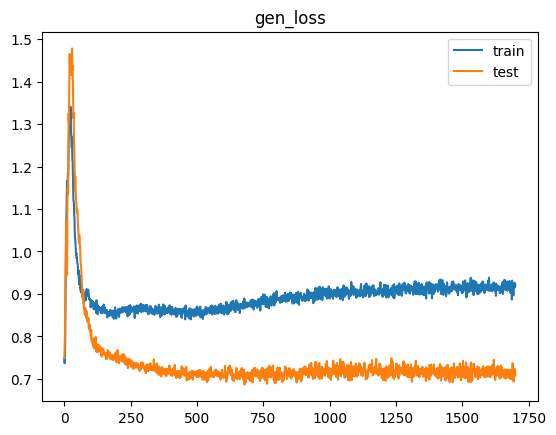

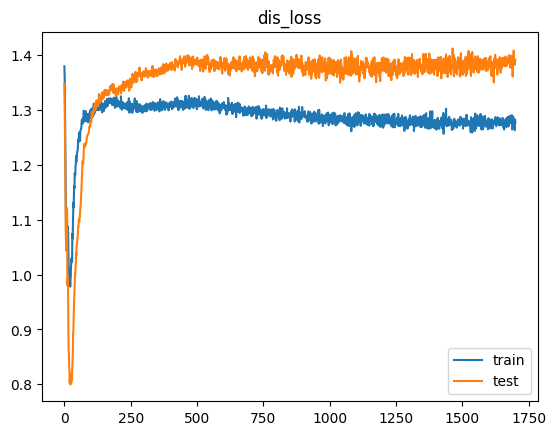

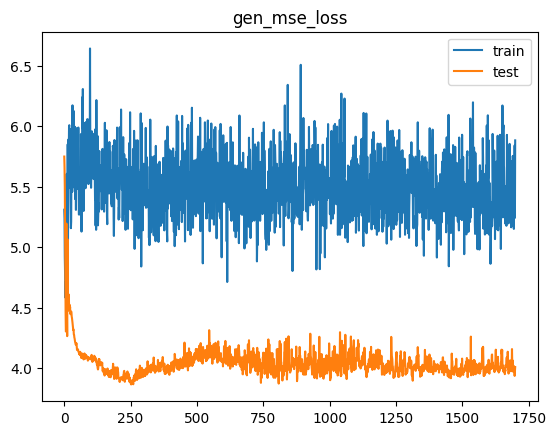

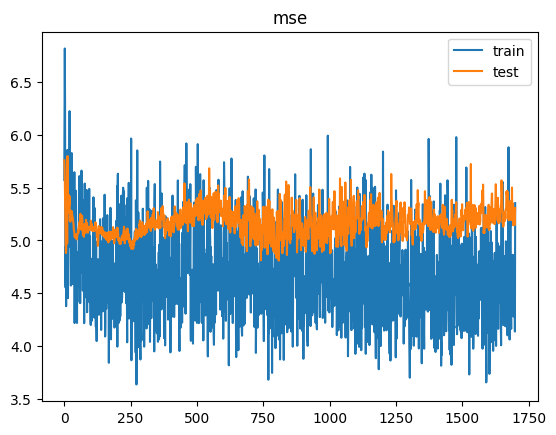

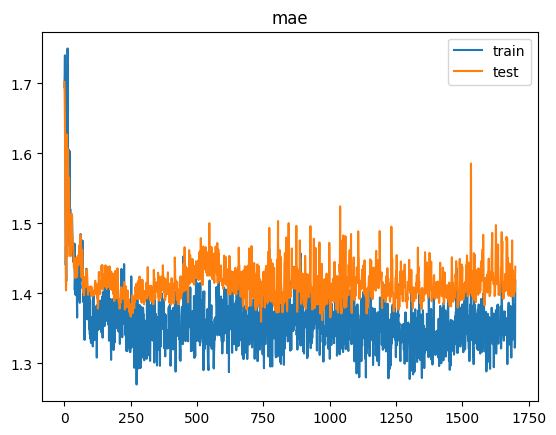

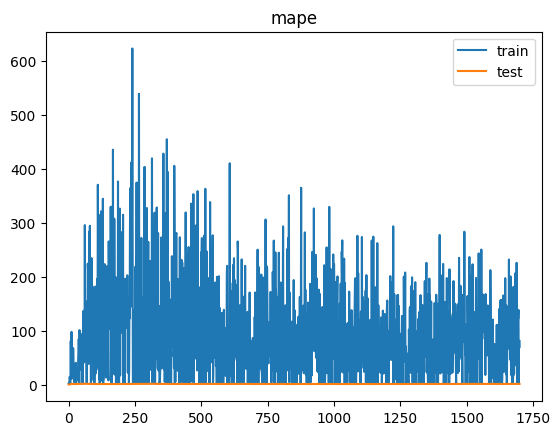

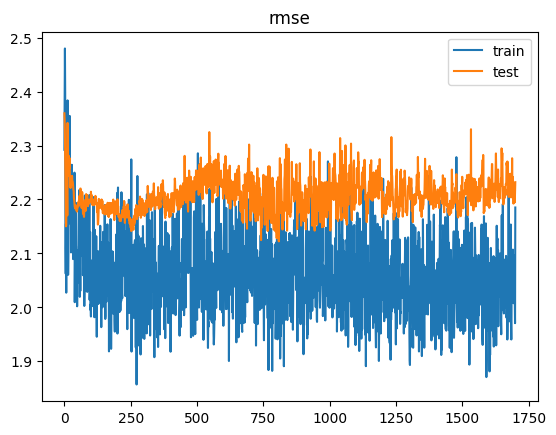

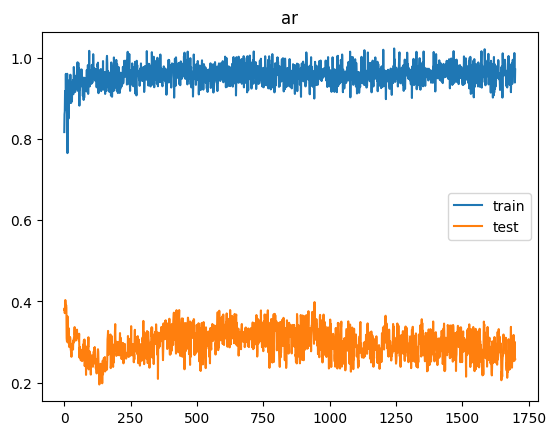

2/2 [==============================] - 0s 9ms/step


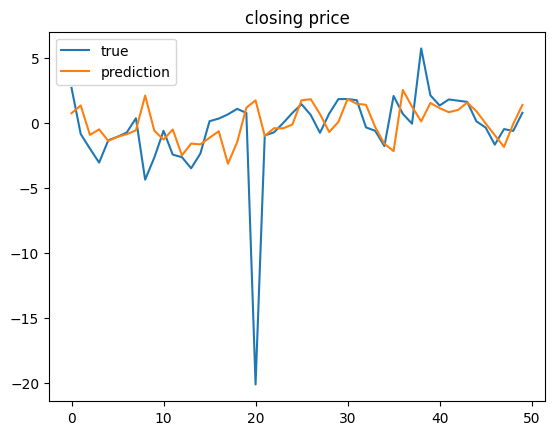

[MSE Baseline] train: 4.626483091110225  test: 4.679867713895856
Delta time with epochs = 1700: 0:37:29.220245
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 lstm_12 (LSTM)              (None, 5, 10)             720       
                                                                 
 batch_normalization_12 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_30 (Dropout)        (None, 5, 10)             0         
                                                                 
 lstm_13 (LSTM

Time for epoch 53 is 1.289823055267334 sec Generator Loss: 1.053952693939209,  Discriminator_loss: 1.1843289136886597
Time for epoch 54 is 1.30135178565979 sec Generator Loss: 1.0489065647125244,  Discriminator_loss: 1.177728533744812
Time for epoch 55 is 1.3940799236297607 sec Generator Loss: 1.042350172996521,  Discriminator_loss: 1.1935372352600098
Time for epoch 56 is 1.3621766567230225 sec Generator Loss: 1.0333833694458008,  Discriminator_loss: 1.214111089706421
Time for epoch 57 is 1.3121495246887207 sec Generator Loss: 1.040272831916809,  Discriminator_loss: 1.1963741779327393
Time for epoch 58 is 1.3475449085235596 sec Generator Loss: 1.027901291847229,  Discriminator_loss: 1.2127035856246948
Time for epoch 59 is 1.3022830486297607 sec Generator Loss: 1.0216002464294434,  Discriminator_loss: 1.2107300758361816
Time for epoch 60 is 1.3307149410247803 sec Generator Loss: 1.0196505784988403,  Discriminator_loss: 1.213462471961975
Time for epoch 61 is 1.374612808227539 sec Generat

Time for epoch 122 is 1.3374264240264893 sec Generator Loss: 0.8852402567863464,  Discriminator_loss: 1.2923039197921753
Time for epoch 123 is 1.3131706714630127 sec Generator Loss: 0.8740219473838806,  Discriminator_loss: 1.295094609260559
Time for epoch 124 is 1.3407206535339355 sec Generator Loss: 0.8848065733909607,  Discriminator_loss: 1.3006248474121094
Time for epoch 125 is 1.27809739112854 sec Generator Loss: 0.8826404809951782,  Discriminator_loss: 1.2928946018218994
Time for epoch 126 is 1.293973684310913 sec Generator Loss: 0.8783020377159119,  Discriminator_loss: 1.2998687028884888
Time for epoch 127 is 1.595231294631958 sec Generator Loss: 0.8846005201339722,  Discriminator_loss: 1.299552083015442
Time for epoch 128 is 1.4835717678070068 sec Generator Loss: 0.8840913772583008,  Discriminator_loss: 1.2903608083724976
Time for epoch 129 is 1.5815963745117188 sec Generator Loss: 0.8782728910446167,  Discriminator_loss: 1.307466983795166
Time for epoch 130 is 1.415837287902832

Time for epoch 191 is 1.302832841873169 sec Generator Loss: 0.8448054194450378,  Discriminator_loss: 1.320108413696289
Time for epoch 192 is 1.5047826766967773 sec Generator Loss: 0.8468643426895142,  Discriminator_loss: 1.3183790445327759
Time for epoch 193 is 1.5258266925811768 sec Generator Loss: 0.8382079601287842,  Discriminator_loss: 1.3254083395004272
Time for epoch 194 is 1.547468662261963 sec Generator Loss: 0.8509323000907898,  Discriminator_loss: 1.3217233419418335
Time for epoch 195 is 1.319122552871704 sec Generator Loss: 0.8362835645675659,  Discriminator_loss: 1.336714506149292
Time for epoch 196 is 1.6406314373016357 sec Generator Loss: 0.838537335395813,  Discriminator_loss: 1.3298985958099365
Time for epoch 197 is 1.4420878887176514 sec Generator Loss: 0.8442459106445312,  Discriminator_loss: 1.3250634670257568
Time for epoch 198 is 1.3341047763824463 sec Generator Loss: 0.8391249179840088,  Discriminator_loss: 1.3232899904251099
Time for epoch 199 is 1.32843422889709

Time for epoch 260 is 1.3055059909820557 sec Generator Loss: 0.8477144241333008,  Discriminator_loss: 1.3219307661056519
Time for epoch 261 is 1.4035160541534424 sec Generator Loss: 0.8470038771629333,  Discriminator_loss: 1.321664810180664
Time for epoch 262 is 1.5150742530822754 sec Generator Loss: 0.8422967195510864,  Discriminator_loss: 1.3263843059539795
Time for epoch 263 is 1.4852280616760254 sec Generator Loss: 0.8508129119873047,  Discriminator_loss: 1.3156522512435913
Time for epoch 264 is 1.566692590713501 sec Generator Loss: 0.862075686454773,  Discriminator_loss: 1.3076748847961426
Time for epoch 265 is 1.3626291751861572 sec Generator Loss: 0.8431137800216675,  Discriminator_loss: 1.3211225271224976
Time for epoch 266 is 1.4724953174591064 sec Generator Loss: 0.8518120050430298,  Discriminator_loss: 1.3195319175720215
Time for epoch 267 is 1.388016939163208 sec Generator Loss: 0.8483250141143799,  Discriminator_loss: 1.316664218902588
Time for epoch 268 is 1.4511463642120

Time for epoch 329 is 1.343031406402588 sec Generator Loss: 0.8636100888252258,  Discriminator_loss: 1.3084681034088135
Time for epoch 330 is 1.470433235168457 sec Generator Loss: 0.8687599897384644,  Discriminator_loss: 1.2954012155532837
Time for epoch 331 is 1.8413074016571045 sec Generator Loss: 0.8608456254005432,  Discriminator_loss: 1.309187412261963
Time for epoch 332 is 1.8766775131225586 sec Generator Loss: 0.8663430213928223,  Discriminator_loss: 1.3060574531555176
Time for epoch 333 is 1.794604778289795 sec Generator Loss: 0.8715720176696777,  Discriminator_loss: 1.3053257465362549
Time for epoch 334 is 1.5421526432037354 sec Generator Loss: 0.8675545454025269,  Discriminator_loss: 1.3028501272201538
Time for epoch 335 is 1.7859764099121094 sec Generator Loss: 0.8715025186538696,  Discriminator_loss: 1.2975187301635742
Time for epoch 336 is 2.1071829795837402 sec Generator Loss: 0.8675816059112549,  Discriminator_loss: 1.3100115060806274
Time for epoch 337 is 2.324216365814

Time for epoch 398 is 1.5763435363769531 sec Generator Loss: 0.860593318939209,  Discriminator_loss: 1.3123782873153687
Time for epoch 399 is 1.580007791519165 sec Generator Loss: 0.8677626252174377,  Discriminator_loss: 1.3072539567947388
Time for epoch 400 is 1.6447865962982178 sec Generator Loss: 0.8802535533905029,  Discriminator_loss: 1.2931617498397827
Time for epoch 401 is 1.5667388439178467 sec Generator Loss: 0.8740844130516052,  Discriminator_loss: 1.299333930015564
Time for epoch 402 is 1.5588476657867432 sec Generator Loss: 0.8732147812843323,  Discriminator_loss: 1.3099925518035889
Time for epoch 403 is 1.5933213233947754 sec Generator Loss: 0.8873113989830017,  Discriminator_loss: 1.3008366823196411
Time for epoch 404 is 1.5791068077087402 sec Generator Loss: 0.8723050355911255,  Discriminator_loss: 1.3040128946304321
Time for epoch 405 is 1.505234718322754 sec Generator Loss: 0.8665805459022522,  Discriminator_loss: 1.3054566383361816
Time for epoch 406 is 1.725512981414

Time for epoch 467 is 1.614759922027588 sec Generator Loss: 0.8849895000457764,  Discriminator_loss: 1.2942396402359009
Time for epoch 468 is 1.642871379852295 sec Generator Loss: 0.8812904953956604,  Discriminator_loss: 1.285610318183899
Time for epoch 469 is 1.8937649726867676 sec Generator Loss: 0.8807690739631653,  Discriminator_loss: 1.3019731044769287
Time for epoch 470 is 1.8113682270050049 sec Generator Loss: 0.8864268064498901,  Discriminator_loss: 1.295244812965393
Time for epoch 471 is 1.5675337314605713 sec Generator Loss: 0.8829629421234131,  Discriminator_loss: 1.2991273403167725
Time for epoch 472 is 1.6526210308074951 sec Generator Loss: 0.8823161721229553,  Discriminator_loss: 1.2955843210220337
Time for epoch 473 is 1.6544272899627686 sec Generator Loss: 0.8965480327606201,  Discriminator_loss: 1.2884429693222046
Time for epoch 474 is 1.603257417678833 sec Generator Loss: 0.8863750696182251,  Discriminator_loss: 1.288429617881775
Time for epoch 475 is 1.57821798324584

Time for epoch 535 is 1.4114904403686523 sec Generator Loss: 0.890605092048645,  Discriminator_loss: 1.292089819908142
Time for epoch 536 is 1.469099521636963 sec Generator Loss: 0.8919612169265747,  Discriminator_loss: 1.2868927717208862
Time for epoch 537 is 1.4508912563323975 sec Generator Loss: 0.8967657089233398,  Discriminator_loss: 1.2818164825439453
Time for epoch 538 is 1.3598239421844482 sec Generator Loss: 0.8784816861152649,  Discriminator_loss: 1.3043760061264038
Time for epoch 539 is 1.4386694431304932 sec Generator Loss: 0.8884955048561096,  Discriminator_loss: 1.2908271551132202
Time for epoch 540 is 1.414910078048706 sec Generator Loss: 0.8895987272262573,  Discriminator_loss: 1.2900149822235107
Time for epoch 541 is 1.446894645690918 sec Generator Loss: 0.9001994729042053,  Discriminator_loss: 1.2860835790634155
Time for epoch 542 is 1.498079538345337 sec Generator Loss: 0.889119029045105,  Discriminator_loss: 1.2960147857666016
Time for epoch 543 is 1.499345302581787

Time for epoch 604 is 1.555424451828003 sec Generator Loss: 0.8946026563644409,  Discriminator_loss: 1.2873705625534058
Time for epoch 605 is 1.591949462890625 sec Generator Loss: 0.8903766870498657,  Discriminator_loss: 1.2900999784469604
Time for epoch 606 is 1.747342824935913 sec Generator Loss: 0.9087707996368408,  Discriminator_loss: 1.2829723358154297
Time for epoch 607 is 1.6968638896942139 sec Generator Loss: 0.8946821093559265,  Discriminator_loss: 1.3011796474456787
Time for epoch 608 is 1.790459156036377 sec Generator Loss: 0.8942872881889343,  Discriminator_loss: 1.2902426719665527
Time for epoch 609 is 1.7490959167480469 sec Generator Loss: 0.8869104981422424,  Discriminator_loss: 1.2943097352981567
Time for epoch 610 is 1.7245616912841797 sec Generator Loss: 0.8862435221672058,  Discriminator_loss: 1.2911702394485474
Time for epoch 611 is 1.6917688846588135 sec Generator Loss: 0.8845022916793823,  Discriminator_loss: 1.289198637008667
Time for epoch 612 is 1.6136143207550

Time for epoch 672 is 1.222149133682251 sec Generator Loss: 0.8939736485481262,  Discriminator_loss: 1.2918466329574585
Time for epoch 673 is 1.2727608680725098 sec Generator Loss: 0.8990147113800049,  Discriminator_loss: 1.2879873514175415
Time for epoch 674 is 1.250821590423584 sec Generator Loss: 0.9035331010818481,  Discriminator_loss: 1.2792954444885254
Time for epoch 675 is 1.2842297554016113 sec Generator Loss: 0.9067504405975342,  Discriminator_loss: 1.2898435592651367
Time for epoch 676 is 1.2642838954925537 sec Generator Loss: 0.8802198767662048,  Discriminator_loss: 1.2857089042663574
Time for epoch 677 is 1.2954399585723877 sec Generator Loss: 0.9056246876716614,  Discriminator_loss: 1.2805778980255127
Time for epoch 678 is 1.2529947757720947 sec Generator Loss: 0.9071580767631531,  Discriminator_loss: 1.2884712219238281
Time for epoch 679 is 1.2726621627807617 sec Generator Loss: 0.9018433690071106,  Discriminator_loss: 1.2834688425064087
Time for epoch 680 is 1.2774736881

Time for epoch 741 is 1.3315825462341309 sec Generator Loss: 0.8982567191123962,  Discriminator_loss: 1.2913461923599243
Time for epoch 742 is 1.2948110103607178 sec Generator Loss: 0.9084751605987549,  Discriminator_loss: 1.2815613746643066
Time for epoch 743 is 1.2836084365844727 sec Generator Loss: 0.9133237600326538,  Discriminator_loss: 1.278122067451477
Time for epoch 744 is 1.3616833686828613 sec Generator Loss: 0.9006655812263489,  Discriminator_loss: 1.290452003479004
Time for epoch 745 is 1.3002805709838867 sec Generator Loss: 0.8930001854896545,  Discriminator_loss: 1.3002943992614746
Time for epoch 746 is 1.2400829792022705 sec Generator Loss: 0.9039206504821777,  Discriminator_loss: 1.2883063554763794
Time for epoch 747 is 1.2342801094055176 sec Generator Loss: 0.9021813273429871,  Discriminator_loss: 1.292070984840393
Time for epoch 748 is 1.2481675148010254 sec Generator Loss: 0.8881669044494629,  Discriminator_loss: 1.2957009077072144
Time for epoch 749 is 1.24403047561

Time for epoch 810 is 1.2241556644439697 sec Generator Loss: 0.903423547744751,  Discriminator_loss: 1.2945740222930908
Time for epoch 811 is 1.3170497417449951 sec Generator Loss: 0.910108208656311,  Discriminator_loss: 1.2809536457061768
Time for epoch 812 is 1.265462875366211 sec Generator Loss: 0.9150814414024353,  Discriminator_loss: 1.284928560256958
Time for epoch 813 is 1.2518839836120605 sec Generator Loss: 0.8938336968421936,  Discriminator_loss: 1.2854928970336914
Time for epoch 814 is 1.252748966217041 sec Generator Loss: 0.8979789018630981,  Discriminator_loss: 1.2829512357711792
Time for epoch 815 is 1.2677228450775146 sec Generator Loss: 0.9136932492256165,  Discriminator_loss: 1.2713338136672974
Time for epoch 816 is 1.325606346130371 sec Generator Loss: 0.900814414024353,  Discriminator_loss: 1.2789356708526611
Time for epoch 817 is 1.312690019607544 sec Generator Loss: 0.9078312516212463,  Discriminator_loss: 1.2915054559707642
Time for epoch 818 is 1.232966661453247 

Time for epoch 879 is 1.4083878993988037 sec Generator Loss: 0.8993225693702698,  Discriminator_loss: 1.2836493253707886
Time for epoch 880 is 1.3518743515014648 sec Generator Loss: 0.8933659791946411,  Discriminator_loss: 1.2950880527496338
Time for epoch 881 is 1.3831653594970703 sec Generator Loss: 0.886368989944458,  Discriminator_loss: 1.3035318851470947
Time for epoch 882 is 1.3720107078552246 sec Generator Loss: 0.8881311416625977,  Discriminator_loss: 1.2939666509628296
Time for epoch 883 is 1.351391077041626 sec Generator Loss: 0.9057155847549438,  Discriminator_loss: 1.2874504327774048
Time for epoch 884 is 1.4119329452514648 sec Generator Loss: 0.8853545784950256,  Discriminator_loss: 1.2993907928466797
Time for epoch 885 is 1.3692002296447754 sec Generator Loss: 0.8983705639839172,  Discriminator_loss: 1.284200668334961
Time for epoch 886 is 1.395465612411499 sec Generator Loss: 0.8972130417823792,  Discriminator_loss: 1.2870687246322632
Time for epoch 887 is 1.292931556701

Time for epoch 948 is 1.2500519752502441 sec Generator Loss: 0.8927982449531555,  Discriminator_loss: 1.2983238697052002
Time for epoch 949 is 1.322291612625122 sec Generator Loss: 0.8942118883132935,  Discriminator_loss: 1.2977663278579712
Time for epoch 950 is 1.3216912746429443 sec Generator Loss: 0.8893228769302368,  Discriminator_loss: 1.2945330142974854
Time for epoch 951 is 1.3184938430786133 sec Generator Loss: 0.8922545313835144,  Discriminator_loss: 1.2804796695709229
Time for epoch 952 is 1.2725093364715576 sec Generator Loss: 0.8841439485549927,  Discriminator_loss: 1.2913070917129517
Time for epoch 953 is 1.487417459487915 sec Generator Loss: 0.8971665501594543,  Discriminator_loss: 1.2881581783294678
Time for epoch 954 is 1.4755992889404297 sec Generator Loss: 0.9096836447715759,  Discriminator_loss: 1.2760087251663208
Time for epoch 955 is 1.4748220443725586 sec Generator Loss: 0.8999133706092834,  Discriminator_loss: 1.291994333267212
Time for epoch 956 is 1.41827178001

Time for epoch 1016 is 1.3884155750274658 sec Generator Loss: 0.9056653380393982,  Discriminator_loss: 1.2901051044464111
Time for epoch 1017 is 1.3612356185913086 sec Generator Loss: 0.9081461429595947,  Discriminator_loss: 1.2823935747146606
Time for epoch 1018 is 1.2952654361724854 sec Generator Loss: 0.9005773067474365,  Discriminator_loss: 1.2875866889953613
Time for epoch 1019 is 1.3537745475769043 sec Generator Loss: 0.8964614868164062,  Discriminator_loss: 1.2872722148895264
Time for epoch 1020 is 1.4159820079803467 sec Generator Loss: 0.8980060815811157,  Discriminator_loss: 1.2838224172592163
Time for epoch 1021 is 1.3864688873291016 sec Generator Loss: 0.897930383682251,  Discriminator_loss: 1.2880821228027344
Time for epoch 1022 is 1.2597339153289795 sec Generator Loss: 0.8970098495483398,  Discriminator_loss: 1.2917945384979248
Time for epoch 1023 is 1.263550043106079 sec Generator Loss: 0.8814902305603027,  Discriminator_loss: 1.2997779846191406
Time for epoch 1024 is 1.2

Time for epoch 1084 is 1.2965781688690186 sec Generator Loss: 0.9044164419174194,  Discriminator_loss: 1.2855254411697388
Time for epoch 1085 is 1.3128118515014648 sec Generator Loss: 0.9167414903640747,  Discriminator_loss: 1.281563401222229
Time for epoch 1086 is 1.2949600219726562 sec Generator Loss: 0.8980029225349426,  Discriminator_loss: 1.2934397459030151
Time for epoch 1087 is 1.261500597000122 sec Generator Loss: 0.8984708786010742,  Discriminator_loss: 1.287039041519165
Time for epoch 1088 is 1.365049123764038 sec Generator Loss: 0.9121690392494202,  Discriminator_loss: 1.2850067615509033
Time for epoch 1089 is 1.434593915939331 sec Generator Loss: 0.9028723239898682,  Discriminator_loss: 1.2782689332962036
Time for epoch 1090 is 1.3957293033599854 sec Generator Loss: 0.9009549021720886,  Discriminator_loss: 1.2933838367462158
Time for epoch 1091 is 1.3609471321105957 sec Generator Loss: 0.9048892855644226,  Discriminator_loss: 1.290744423866272
Time for epoch 1092 is 1.39801

Time for epoch 1152 is 1.3910372257232666 sec Generator Loss: 0.903350830078125,  Discriminator_loss: 1.2883989810943604
Time for epoch 1153 is 1.3389630317687988 sec Generator Loss: 0.905535876750946,  Discriminator_loss: 1.2774385213851929
Time for epoch 1154 is 1.5941925048828125 sec Generator Loss: 0.9085428714752197,  Discriminator_loss: 1.2796375751495361
Time for epoch 1155 is 1.5969934463500977 sec Generator Loss: 0.9130672812461853,  Discriminator_loss: 1.2835099697113037
Time for epoch 1156 is 1.5237116813659668 sec Generator Loss: 0.904285728931427,  Discriminator_loss: 1.2877861261367798
Time for epoch 1157 is 1.5421288013458252 sec Generator Loss: 0.9185442328453064,  Discriminator_loss: 1.280646800994873
Time for epoch 1158 is 1.570403814315796 sec Generator Loss: 0.8998706936836243,  Discriminator_loss: 1.2968404293060303
Time for epoch 1159 is 1.5306508541107178 sec Generator Loss: 0.9219246506690979,  Discriminator_loss: 1.2771553993225098
Time for epoch 1160 is 1.5386

Time for epoch 1220 is 1.5045311450958252 sec Generator Loss: 0.9091321229934692,  Discriminator_loss: 1.2869733572006226
Time for epoch 1221 is 1.4276819229125977 sec Generator Loss: 0.9102657437324524,  Discriminator_loss: 1.2794654369354248
Time for epoch 1222 is 1.5337755680084229 sec Generator Loss: 0.9184325337409973,  Discriminator_loss: 1.2869008779525757
Time for epoch 1223 is 1.4153742790222168 sec Generator Loss: 0.9076167941093445,  Discriminator_loss: 1.2778432369232178
Time for epoch 1224 is 1.3490371704101562 sec Generator Loss: 0.9046000242233276,  Discriminator_loss: 1.2928776741027832
Time for epoch 1225 is 1.3913626670837402 sec Generator Loss: 0.9151270389556885,  Discriminator_loss: 1.272694706916809
Time for epoch 1226 is 1.3749477863311768 sec Generator Loss: 0.9050544500350952,  Discriminator_loss: 1.2912464141845703
Time for epoch 1227 is 1.4200921058654785 sec Generator Loss: 0.9170731902122498,  Discriminator_loss: 1.2734174728393555
Time for epoch 1228 is 1.

Time for epoch 1288 is 1.3594059944152832 sec Generator Loss: 0.9167855381965637,  Discriminator_loss: 1.271223545074463
Time for epoch 1289 is 1.3436381816864014 sec Generator Loss: 0.9095404744148254,  Discriminator_loss: 1.2941001653671265
Time for epoch 1290 is 1.331693172454834 sec Generator Loss: 0.9131245017051697,  Discriminator_loss: 1.2816534042358398
Time for epoch 1291 is 1.3401150703430176 sec Generator Loss: 0.9094685912132263,  Discriminator_loss: 1.279170036315918
Time for epoch 1292 is 1.3428614139556885 sec Generator Loss: 0.9321126937866211,  Discriminator_loss: 1.2737904787063599
Time for epoch 1293 is 1.3383324146270752 sec Generator Loss: 0.9149715900421143,  Discriminator_loss: 1.2846157550811768
Time for epoch 1294 is 1.3191776275634766 sec Generator Loss: 0.9100773930549622,  Discriminator_loss: 1.2788671255111694
Time for epoch 1295 is 1.3457551002502441 sec Generator Loss: 0.9225364923477173,  Discriminator_loss: 1.2829533815383911
Time for epoch 1296 is 1.36

Time for epoch 1356 is 1.3644063472747803 sec Generator Loss: 0.9365575313568115,  Discriminator_loss: 1.2779710292816162
Time for epoch 1357 is 1.3608553409576416 sec Generator Loss: 0.9174773693084717,  Discriminator_loss: 1.2795242071151733
Time for epoch 1358 is 1.341055154800415 sec Generator Loss: 0.9111407995223999,  Discriminator_loss: 1.2787483930587769
Time for epoch 1359 is 1.3852710723876953 sec Generator Loss: 0.9299268126487732,  Discriminator_loss: 1.2741566896438599
Time for epoch 1360 is 1.3497695922851562 sec Generator Loss: 0.8912796974182129,  Discriminator_loss: 1.2913938760757446
Time for epoch 1361 is 1.3350574970245361 sec Generator Loss: 0.9188100695610046,  Discriminator_loss: 1.273201584815979
Time for epoch 1362 is 1.3524892330169678 sec Generator Loss: 0.917777419090271,  Discriminator_loss: 1.2766085863113403
Time for epoch 1363 is 1.2976412773132324 sec Generator Loss: 0.912283718585968,  Discriminator_loss: 1.2917592525482178
Time for epoch 1364 is 1.391

Time for epoch 1424 is 1.3265602588653564 sec Generator Loss: 0.9213666319847107,  Discriminator_loss: 1.2784961462020874
Time for epoch 1425 is 1.368469476699829 sec Generator Loss: 0.9315786361694336,  Discriminator_loss: 1.2693604230880737
Time for epoch 1426 is 1.3756465911865234 sec Generator Loss: 0.9277589321136475,  Discriminator_loss: 1.2764372825622559
Time for epoch 1427 is 1.3657488822937012 sec Generator Loss: 0.9210244417190552,  Discriminator_loss: 1.2775858640670776
Time for epoch 1428 is 1.3243188858032227 sec Generator Loss: 0.9152891635894775,  Discriminator_loss: 1.2847329378128052
Time for epoch 1429 is 1.3426616191864014 sec Generator Loss: 0.9115556478500366,  Discriminator_loss: 1.2752400636672974
Time for epoch 1430 is 1.3223035335540771 sec Generator Loss: 0.9085677862167358,  Discriminator_loss: 1.2824125289916992
Time for epoch 1431 is 1.3350474834442139 sec Generator Loss: 0.9237232208251953,  Discriminator_loss: 1.271134376525879
Time for epoch 1432 is 1.4

Time for epoch 1492 is 1.3735766410827637 sec Generator Loss: 0.9238907694816589,  Discriminator_loss: 1.2781612873077393
Time for epoch 1493 is 1.341468334197998 sec Generator Loss: 0.9033788442611694,  Discriminator_loss: 1.2852015495300293
Time for epoch 1494 is 1.4022495746612549 sec Generator Loss: 0.9113237857818604,  Discriminator_loss: 1.287650465965271
Time for epoch 1495 is 1.3354599475860596 sec Generator Loss: 0.9103175401687622,  Discriminator_loss: 1.2809427976608276
Time for epoch 1496 is 1.3825738430023193 sec Generator Loss: 0.942833662033081,  Discriminator_loss: 1.2642730474472046
Time for epoch 1497 is 1.3521580696105957 sec Generator Loss: 0.9103085994720459,  Discriminator_loss: 1.2785913944244385
Time for epoch 1498 is 1.3572041988372803 sec Generator Loss: 0.91346275806427,  Discriminator_loss: 1.2838269472122192
Time for epoch 1499 is 1.3606369495391846 sec Generator Loss: 0.9058560729026794,  Discriminator_loss: 1.2858293056488037
Time for epoch 1500 is 1.3704

Time for epoch 1560 is 1.3307082653045654 sec Generator Loss: 0.9249194264411926,  Discriminator_loss: 1.2759467363357544
Time for epoch 1561 is 1.3341422080993652 sec Generator Loss: 0.921987771987915,  Discriminator_loss: 1.2813483476638794
Time for epoch 1562 is 1.4142773151397705 sec Generator Loss: 0.9226377010345459,  Discriminator_loss: 1.2829519510269165
Time for epoch 1563 is 1.3642985820770264 sec Generator Loss: 0.9208081960678101,  Discriminator_loss: 1.271667718887329
Time for epoch 1564 is 1.3572297096252441 sec Generator Loss: 0.9172734618186951,  Discriminator_loss: 1.2744154930114746
Time for epoch 1565 is 1.3865599632263184 sec Generator Loss: 0.9298540949821472,  Discriminator_loss: 1.267655849456787
Time for epoch 1566 is 1.485574722290039 sec Generator Loss: 0.9010258316993713,  Discriminator_loss: 1.2888139486312866
Time for epoch 1567 is 1.4353547096252441 sec Generator Loss: 0.9126262068748474,  Discriminator_loss: 1.2729462385177612
Time for epoch 1568 is 1.536

Time for epoch 1628 is 1.386962890625 sec Generator Loss: 0.9153828620910645,  Discriminator_loss: 1.2812557220458984
Time for epoch 1629 is 1.4035818576812744 sec Generator Loss: 0.9240814447402954,  Discriminator_loss: 1.278058648109436
Time for epoch 1630 is 1.3947720527648926 sec Generator Loss: 0.9208942651748657,  Discriminator_loss: 1.2798893451690674
Time for epoch 1631 is 1.3573286533355713 sec Generator Loss: 0.9254974126815796,  Discriminator_loss: 1.273114800453186
Time for epoch 1632 is 1.36924409866333 sec Generator Loss: 0.9399857521057129,  Discriminator_loss: 1.2793257236480713
Time for epoch 1633 is 1.3407821655273438 sec Generator Loss: 0.9150276780128479,  Discriminator_loss: 1.274967908859253
Time for epoch 1634 is 1.359874963760376 sec Generator Loss: 0.9315147399902344,  Discriminator_loss: 1.2692723274230957
Time for epoch 1635 is 1.4106533527374268 sec Generator Loss: 0.9256921410560608,  Discriminator_loss: 1.2729626893997192
Time for epoch 1636 is 1.403221607

Time for epoch 1696 is 1.530644416809082 sec Generator Loss: 0.9349197149276733,  Discriminator_loss: 1.2720823287963867
Time for epoch 1697 is 1.4034678936004639 sec Generator Loss: 0.915693998336792,  Discriminator_loss: 1.2782636880874634
Time for epoch 1698 is 1.4079065322875977 sec Generator Loss: 0.9223531484603882,  Discriminator_loss: 1.270379900932312
Time for epoch 1699 is 1.403273105621338 sec Generator Loss: 0.9210531115531921,  Discriminator_loss: 1.2797338962554932
Time for epoch 1700 is 1.4022228717803955 sec Generator Loss: 0.9130090475082397,  Discriminator_loss: 1.2803082466125488
Time for epoch 1701 is 1.4281506538391113 sec Generator Loss: 0.9212307333946228,  Discriminator_loss: 1.2748844623565674
Time for epoch 1702 is 1.4235308170318604 sec Generator Loss: 0.9080098867416382,  Discriminator_loss: 1.2764263153076172
Time for epoch 1703 is 1.4422509670257568 sec Generator Loss: 0.9285585284233093,  Discriminator_loss: 1.2670707702636719
Time for epoch 1704 is 1.429

Time for epoch 1764 is 1.3664045333862305 sec Generator Loss: 0.9101624488830566,  Discriminator_loss: 1.2823196649551392
Time for epoch 1765 is 1.4515233039855957 sec Generator Loss: 0.911479651927948,  Discriminator_loss: 1.2816894054412842
Time for epoch 1766 is 1.383256196975708 sec Generator Loss: 0.9247006773948669,  Discriminator_loss: 1.2705446481704712
Time for epoch 1767 is 1.4229118824005127 sec Generator Loss: 0.9106696248054504,  Discriminator_loss: 1.2815051078796387
Time for epoch 1768 is 1.4374134540557861 sec Generator Loss: 0.9343550205230713,  Discriminator_loss: 1.2655733823776245
Time for epoch 1769 is 1.4024038314819336 sec Generator Loss: 0.9335290789604187,  Discriminator_loss: 1.2699602842330933
Time for epoch 1770 is 1.3542797565460205 sec Generator Loss: 0.9093379378318787,  Discriminator_loss: 1.2850286960601807
Time for epoch 1771 is 1.4229495525360107 sec Generator Loss: 0.9314408302307129,  Discriminator_loss: 1.2737833261489868
Time for epoch 1772 is 1.4

Time for epoch 1832 is 1.4223322868347168 sec Generator Loss: 0.9120298027992249,  Discriminator_loss: 1.2824256420135498
Time for epoch 1833 is 1.5976214408874512 sec Generator Loss: 0.9238365292549133,  Discriminator_loss: 1.274030327796936
Time for epoch 1834 is 1.6664199829101562 sec Generator Loss: 0.9240549802780151,  Discriminator_loss: 1.2701494693756104
Time for epoch 1835 is 1.591120958328247 sec Generator Loss: 0.9201192855834961,  Discriminator_loss: 1.2725127935409546
Time for epoch 1836 is 1.634079933166504 sec Generator Loss: 0.9155464768409729,  Discriminator_loss: 1.2746334075927734
Time for epoch 1837 is 1.4609248638153076 sec Generator Loss: 0.9230058193206787,  Discriminator_loss: 1.2707436084747314
Time for epoch 1838 is 1.5132594108581543 sec Generator Loss: 0.9275506138801575,  Discriminator_loss: 1.2736926078796387
Time for epoch 1839 is 1.4684295654296875 sec Generator Loss: 0.9242580533027649,  Discriminator_loss: 1.2774745225906372
Time for epoch 1840 is 1.46

Time for epoch 1900 is 1.5249979496002197 sec Generator Loss: 0.897787868976593,  Discriminator_loss: 1.2864046096801758
Time for epoch 1901 is 1.6679513454437256 sec Generator Loss: 0.9261617660522461,  Discriminator_loss: 1.2723846435546875
Time for epoch 1902 is 1.6264865398406982 sec Generator Loss: 0.9299815893173218,  Discriminator_loss: 1.2717276811599731
Time for epoch 1903 is 1.73128080368042 sec Generator Loss: 0.9154921770095825,  Discriminator_loss: 1.2828370332717896
Time for epoch 1904 is 1.692469835281372 sec Generator Loss: 0.9155558347702026,  Discriminator_loss: 1.2803033590316772
Time for epoch 1905 is 1.5009443759918213 sec Generator Loss: 0.9186766743659973,  Discriminator_loss: 1.27681303024292
Time for epoch 1906 is 1.6354892253875732 sec Generator Loss: 0.9132760167121887,  Discriminator_loss: 1.275455355644226
Time for epoch 1907 is 1.5738773345947266 sec Generator Loss: 0.9206129908561707,  Discriminator_loss: 1.2775989770889282
Time for epoch 1908 is 1.506565

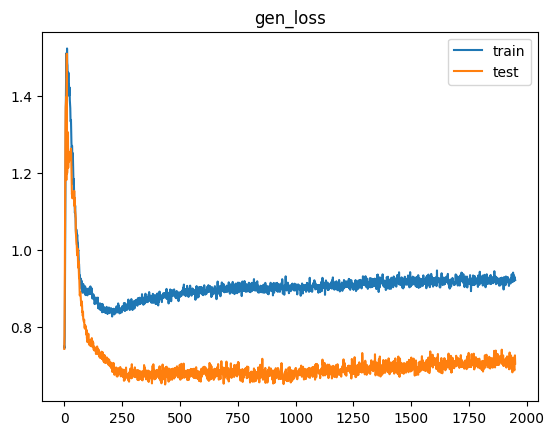

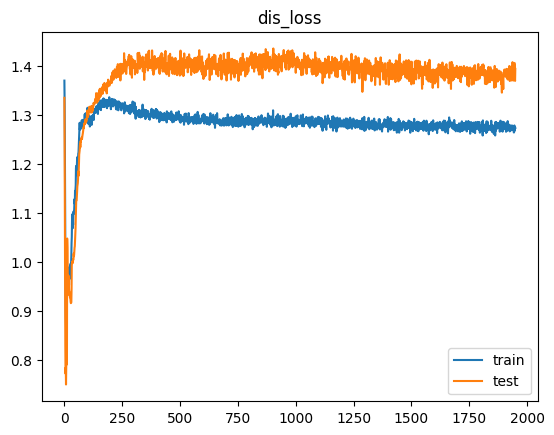

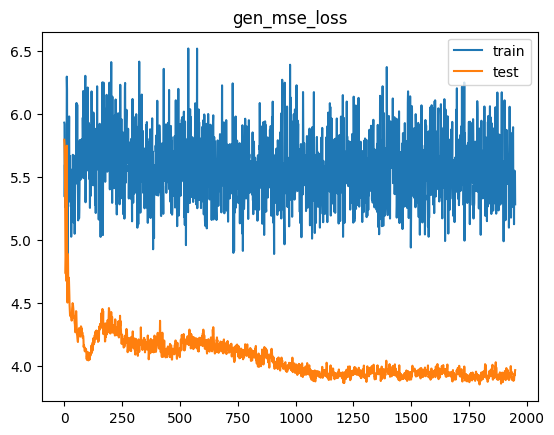

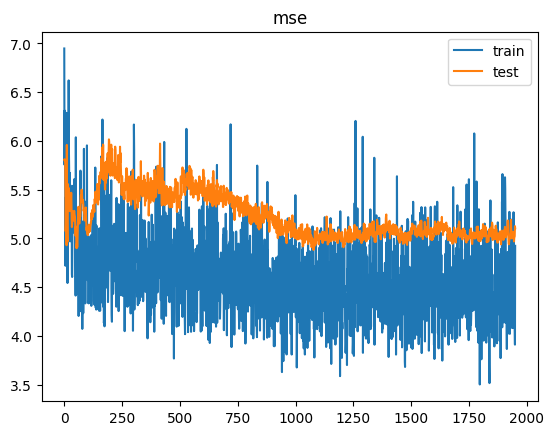

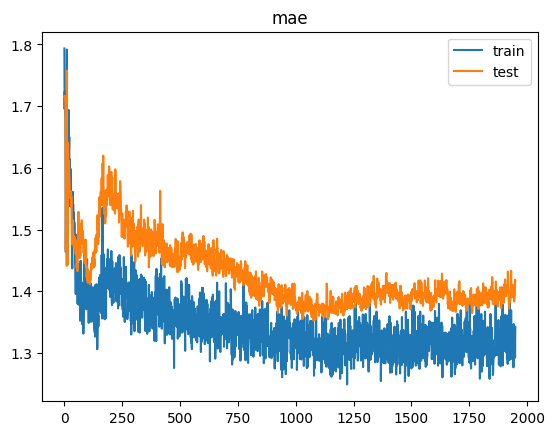

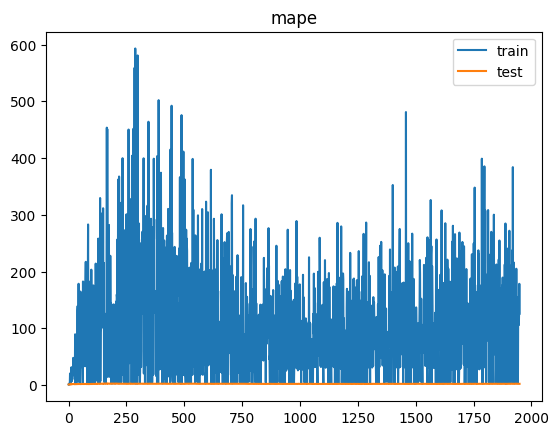

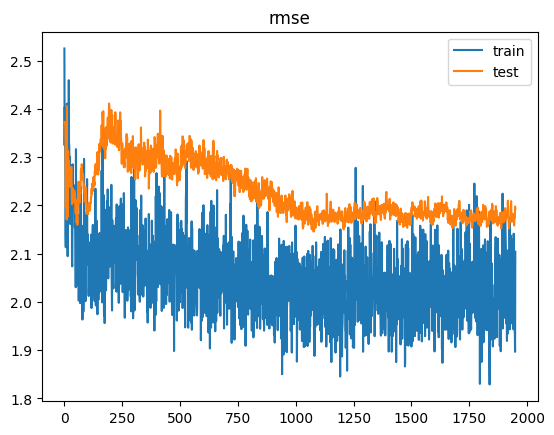

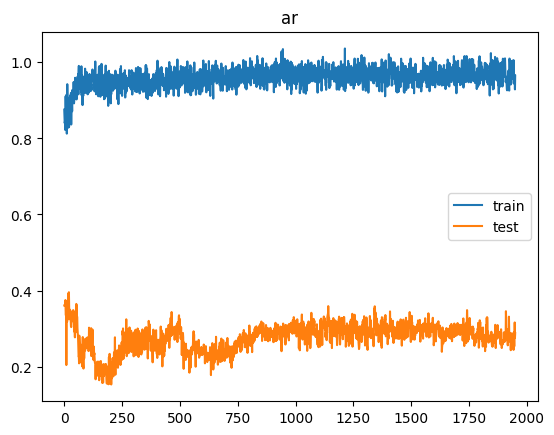

2/2 [==============================] - 0s 10ms/step


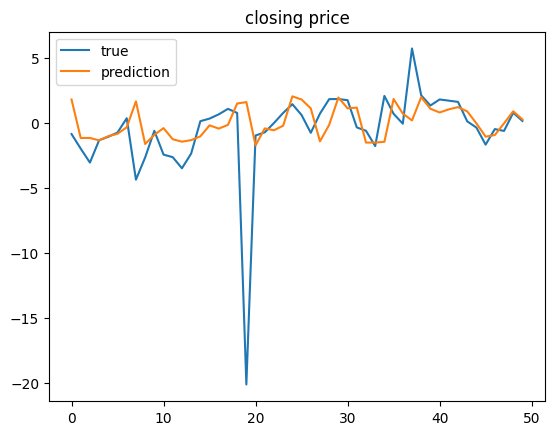

[MSE Baseline] train: 4.832660612791419  test: 4.6881765064049805
Delta time with epochs = 1950: 0:47:38.949706


In [40]:
for epochs in [1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("lstm_ffnn_epochs_{0}.h5".format(epochs))